In [1]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os, sys
import matplotlib as mpl
import healpy as hp
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

from importlib import reload

mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
mpl.rcParams['axes.linewidth'] = 2.
mpl.rcParams['figure.dpi'] = 120

import sensitivity_fit_functions as sff

import seaborn as sns
palette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']

In [17]:
reload(sff)

<module 'sensitivity_fit_functions' from '/mnt/lfs7/user/apizzuto/fast_response_skylab/alert_event_followup/cascade_scripts/sensitivity_fit_functions.py'>

# First, calculate sensitivities vs. dec for different time windows

This first cell does the sensitivity curve fitting for both time windows, with and without smearing, sensitivity and discovery potential, for all 249 alerts. It takes a good ~10ish minutes to run. You can turn the `verbose=True` option on to get printouts of how many alerts it is done with

In [18]:
sens_cols = [sns.xkcd_rgb['navy blue'], sns.xkcd_rgb['navy green'], sns.xkcd_rgb['deep magenta']]
disc_cols = [sns.xkcd_rgb['light navy blue'], sns.xkcd_rgb['lighter green'], sns.xkcd_rgb['light magenta']]

#delta_ts = np.array([1000., 2*86400., 86400*31.])
delta_ts = np.array([1000., 2*86400.])
sensitivities = np.zeros((2, 16))
discoveries = np.zeros((2, 16))

for jj, delta_t in enumerate(delta_ts[:1]):
    casc_calc = sff.CascadeCalculator(delta_t)
    sensitivities[jj], discoveries[jj] = casc_calc.find_all_sens(disc_conf=0.5,
                                                        disc_thresh=1.-0.0013, verbose=False)

[Errno 2] No such file or directory: '/data/user/apizzuto/fast_response_skylab/fast-response/fast_response/cascades_results/sensitivity/index_44_run_128027_event_64761685_time_1000.pkl'


In [29]:
decs_by_ind = casc_calc.cascade_info['dec'][::4]

Next, load the ideal sensitivity for a point source using Tessa's sample (ps_tracks_v003_p02). We will reference this line in our plots

In [21]:
time_labels = [r'$10^3$ s', '2 days']

time_integrated = {'sens': [], 'disc': [], 'sinDec': []}
sinDecs = np.linspace(-0.95, 0.95, 39)
decs = np.arcsin(sinDecs) * 180. / np.pi
for dec in decs[:]:
    try:
        with open('/data/user/apizzuto/fast_response_skylab/fast-response/fast-response/combined_tracks_2.5/results/EstSens_PointSourceTracks_v003p00_10yrs_dec_{:.2f}_degrees.pickle'.format(dec), 'r') as f:
            data = pickle.load(f)
    except:
        try:
            with open('/data/user/apizzuto/fast_response_skylab/fast-response/fast-response/combined_tracks_2.5/results/EstSens_PointSourceTracks_v003p00_10yrs_dec_{:.1f}_degrees.pickle'.format(dec), 'r') as f:
                data = pickle.load(f)
        except:
            continue
    time_integrated['sens'].append(data['sensitivity_flux'])
    time_integrated['disc'].append(data['discovery_flux'])
    time_integrated['sinDec'].append(np.sin(dec * np.pi / 180.))
    #except:
    #    continue
time_integrated['sens'] = np.array(time_integrated['sens'])
time_integrated['disc'] = np.array(time_integrated['disc'])

## Now, make some plots

We will, in addition to comparing to Tessa's analysis, also compare to the fast response analysis sensitivities for a perfectly localized point source (as opposed to using the skymap procedure we use)

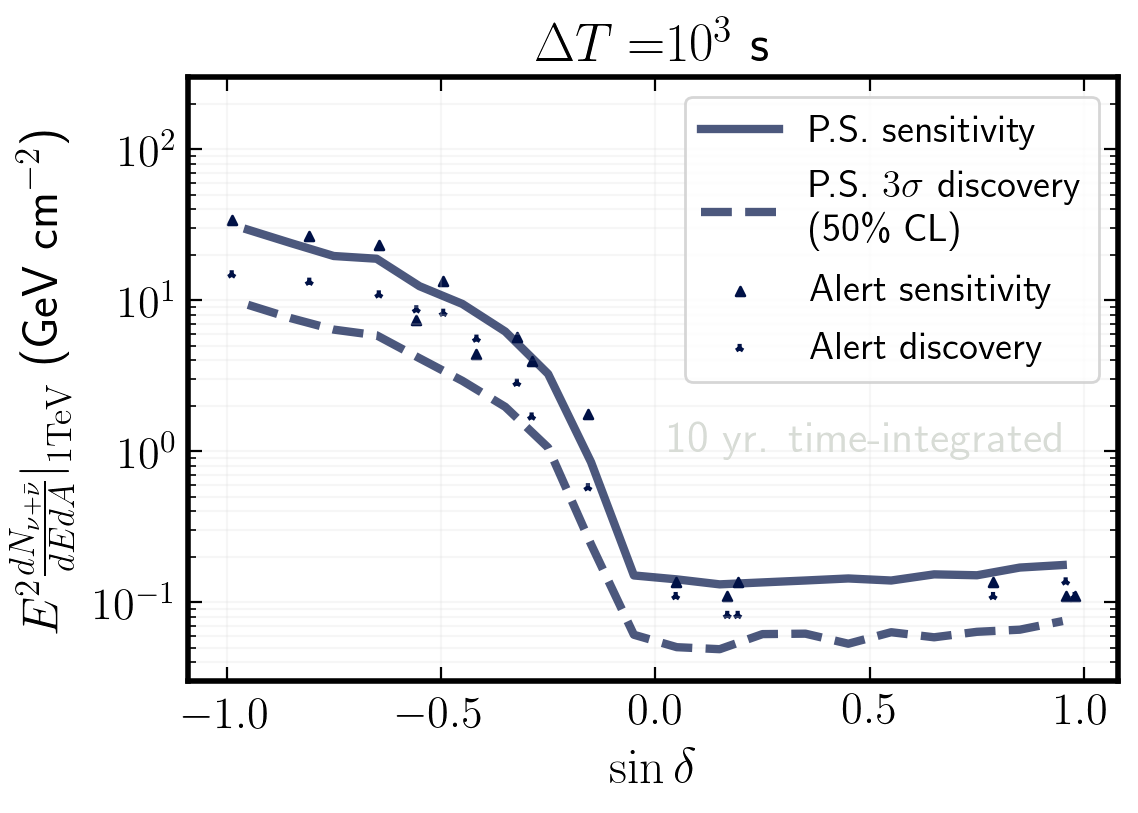

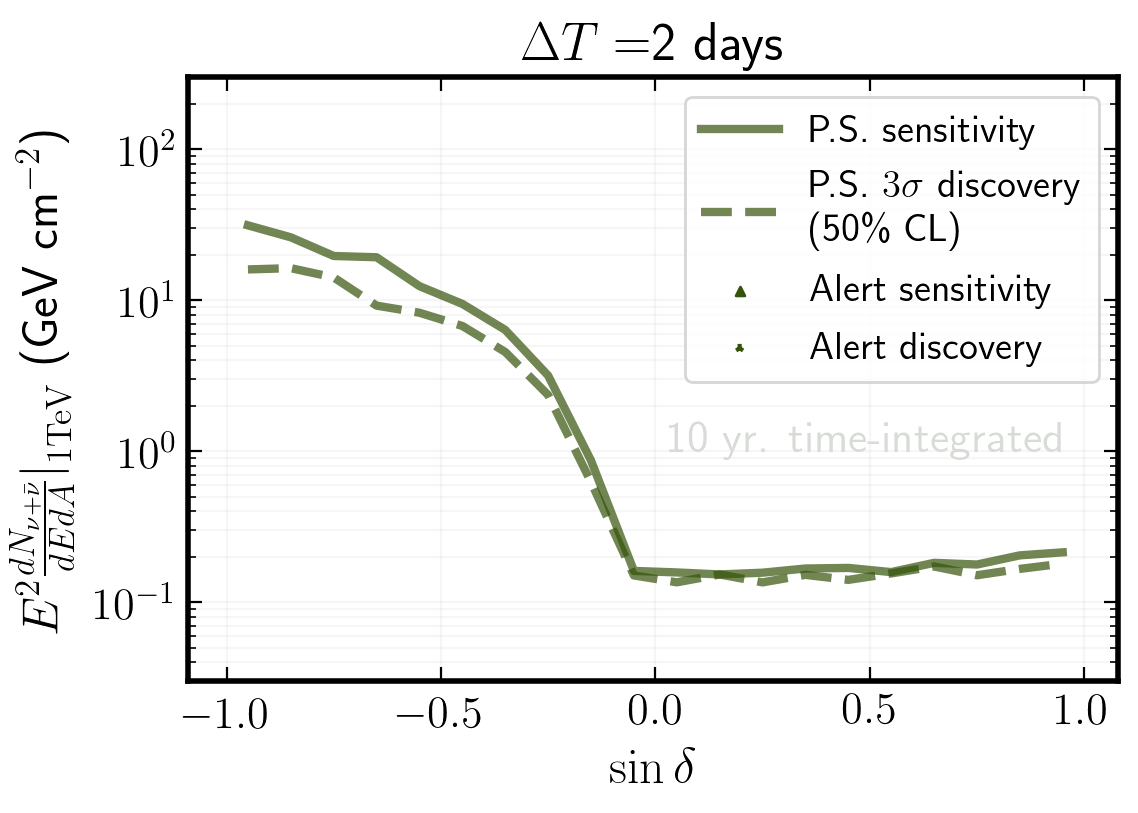

In [31]:
for ii, delta_t in enumerate(delta_ts[:]):
    try:
        fig = plt.figure(dpi=200)
        fig.set_facecolor('white')
        with open('/data/user/apizzuto/fast_response_skylab/dump/ideal_ps_sensitivity_deltaT_{:.2e}_50CL.pkl'.format(delta_t / 86400.), 'rb') as f:
            ideal = pickle.load(f, encoding='latin1')
        msk = sensitivities[ii]*delta_t*1e6 < 1e2
        plt.scatter(np.sin(decs_by_ind)[msk], sensitivities[ii][msk]*delta_t*1e6, 
                    color=sens_cols[ii], 
                    marker='^', label = 'Alert sensitivity', s=10)
        plt.scatter(np.sin(decs_by_ind)[msk], discoveries[ii][msk]*delta_t*1e6, 
                    color=sens_cols[ii], 
                    marker='2', linestyle='--', label = 'Alert discovery', s=10)
        
        plt.plot(ideal['sinDec'], np.array(ideal['sensitivity'])*delta_t*1e6, lw=3, ls='-', 
                 color=sens_cols[ii], label = 'P.S. sensitivity', alpha=0.7)
        plt.plot(ideal['sinDec'], np.array(ideal['discovery'])*delta_t*1e6, lw=3, ls='--', 
                 color=sens_cols[ii], label = r'P.S. $3\sigma$ discovery' +'\n\t(50\% CL)', 
                 alpha=0.7)
        plt.plot(time_integrated['sinDec'], time_integrated['sens'] * 86400. * 10. * 365. * 1e6,
                color = sns.xkcd_rgb['light grey'],
                alpha = 0.7, ls='-')
        plt.plot(time_integrated['sinDec'], time_integrated['disc'] * 86400. * 10. *365.* 1e6, 
                color = sns.xkcd_rgb['light grey'],
                alpha = 0.7, ls='--')

        plt.grid(which='both', alpha=0.2, zorder=1)
        plt.yscale('log')
        plt.legend(loc=1, ncol=1, frameon=True, fontsize=14) #columnspacing=0.6, frameon=False)
        #plt.loglog()
        plt.xlabel(r'$\sin \delta$')
        plt.title(r'$\Delta T = $' + time_labels[ii])
        plt.ylabel(r'$E^2 \frac{dN_{\nu+\bar{\nu}}}{dEdA} \Big|_{\mathrm{1 TeV}}$ (GeV cm$^{-2}$)')
        plt.ylim(3e-2, 3e2)
        plt.text(0.03, 1e0, '10 yr. time-integrated', color = sns.xkcd_rgb['light grey'])
        #plt.xlim(5e0, 1.5e7)
    except Exception as e:
        print(e)
    plt.show()

# Background Trial Panel Plots

The first plots were fairly high level. Now, take a step back and look at distributions and fitting plots

In [32]:
bins = np.linspace(0., 20., 21)

bg = np.array(casc_calc.background_distribution(5, 2.*86400.))
plt.hist(bg, bins=bins, histtype='step', lw=2.)

plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('$N$')
#plt.legend()
plt.title(r'$\Delta T = 2$ days')

plt.show()

TypeError: background_distribution() got an unexpected keyword argument 'smear'

0 25 50 75 100 125 150 175 200 225

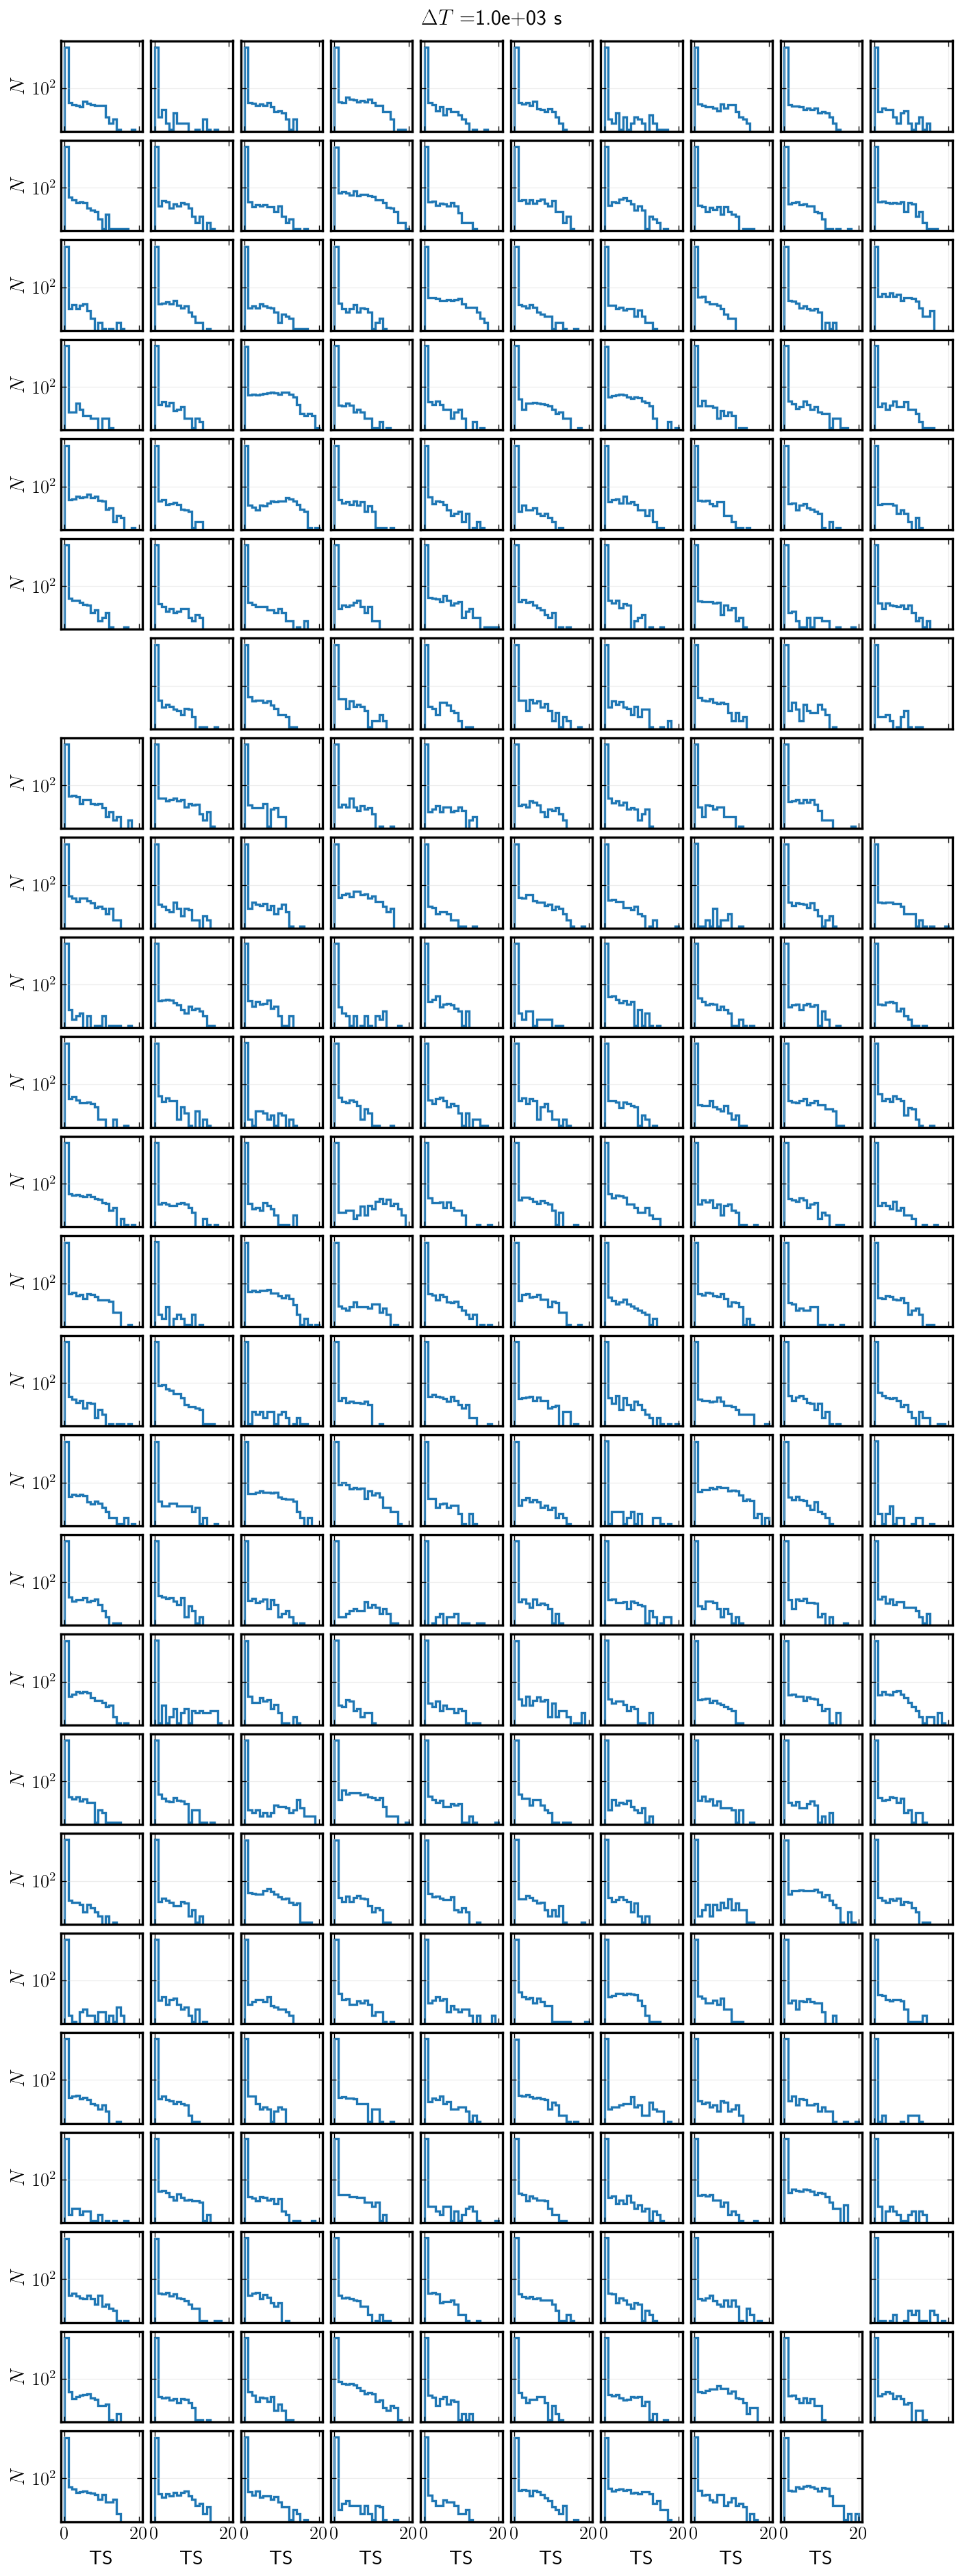

 0 25 50 75 100 125 150 175 200 225

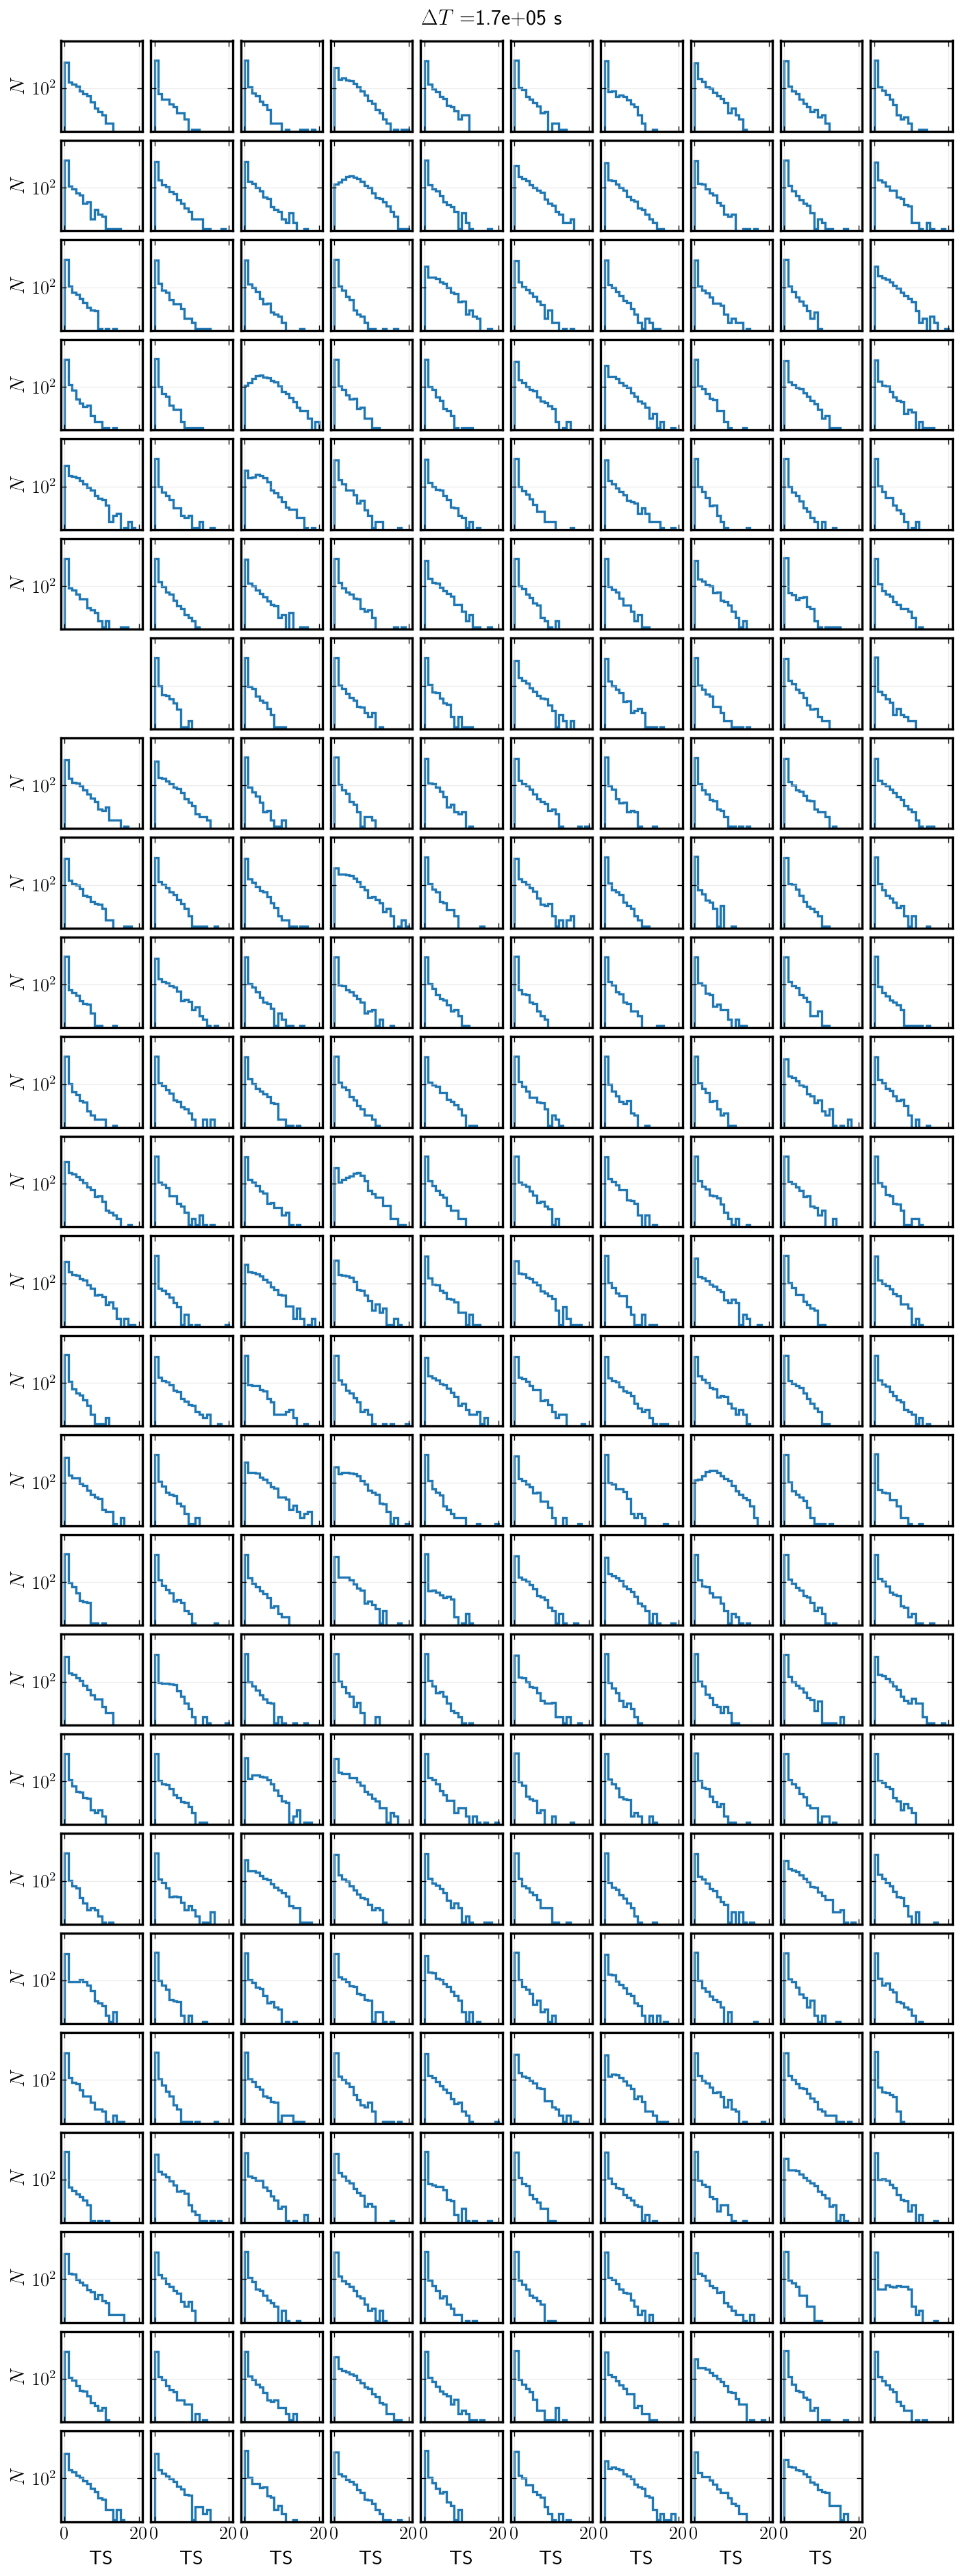

In [8]:
bins = np.linspace(0., 20., 21)
problem_inds = {1000.: [60., 79., 228], 2.*86400: [60]}

for delta_t in np.array([1000., 2.*86400.]):
    fig, aaxs = plt.subplots(ncols=10, nrows=25, figsize=(14,40), 
                            sharey=True, sharex=True)
    used_axs = []
    axs = aaxs.ravel()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    for ind in range(249):
        if ind % 25 == 0:
            print ind, 
        if ind in problem_inds[delta_t]:
            continue
        try:
            bg = np.array(background_distribution(ind, delta_t, smear=True))
            axs[ind].hist(bg, bins=bins, histtype='step', lw=2.)
            #bg = np.array(background_distribution(ind, delta_t, smear=False))
            #axs[ind].hist(bg, bins=bins, histtype='step', lw=2.)
            axs[ind].set_yscale('log')
            axs[ind].set_ylim(0.8e0, 2e4)
            if ind / 10 == 24:
                axs[ind].set_xlabel('TS')
            if ind % 10 == 0:
                axs[ind].set_ylabel('$N$')
            used_axs.append(axs[ind])
        except (IOError, ValueError, IndexError) as err:
            pass
    for ax in axs:
        if ax not in used_axs:
            ax.set_visible(False)
    fig.suptitle(r'$\Delta T = $' + '{:.1e} s'.format(delta_t), y=0.89)
    plt.show()

# Fit validation panel plots

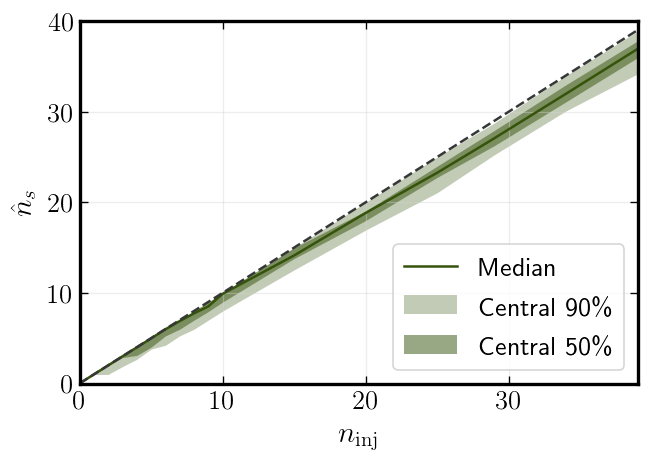

In [17]:
ns_fits_contours_plot(5, 1000., smear=True, show=False, legend=True)
plt.ylim(0., 40)

In [10]:
decs_by_ind[154]

-0.6503096792930871

0 25 50 75 list index out of range
100 125 150 Index 154 has max 0.0


/home/apizzuto/.venvs/fast_response/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


175 200 225 list index out of range


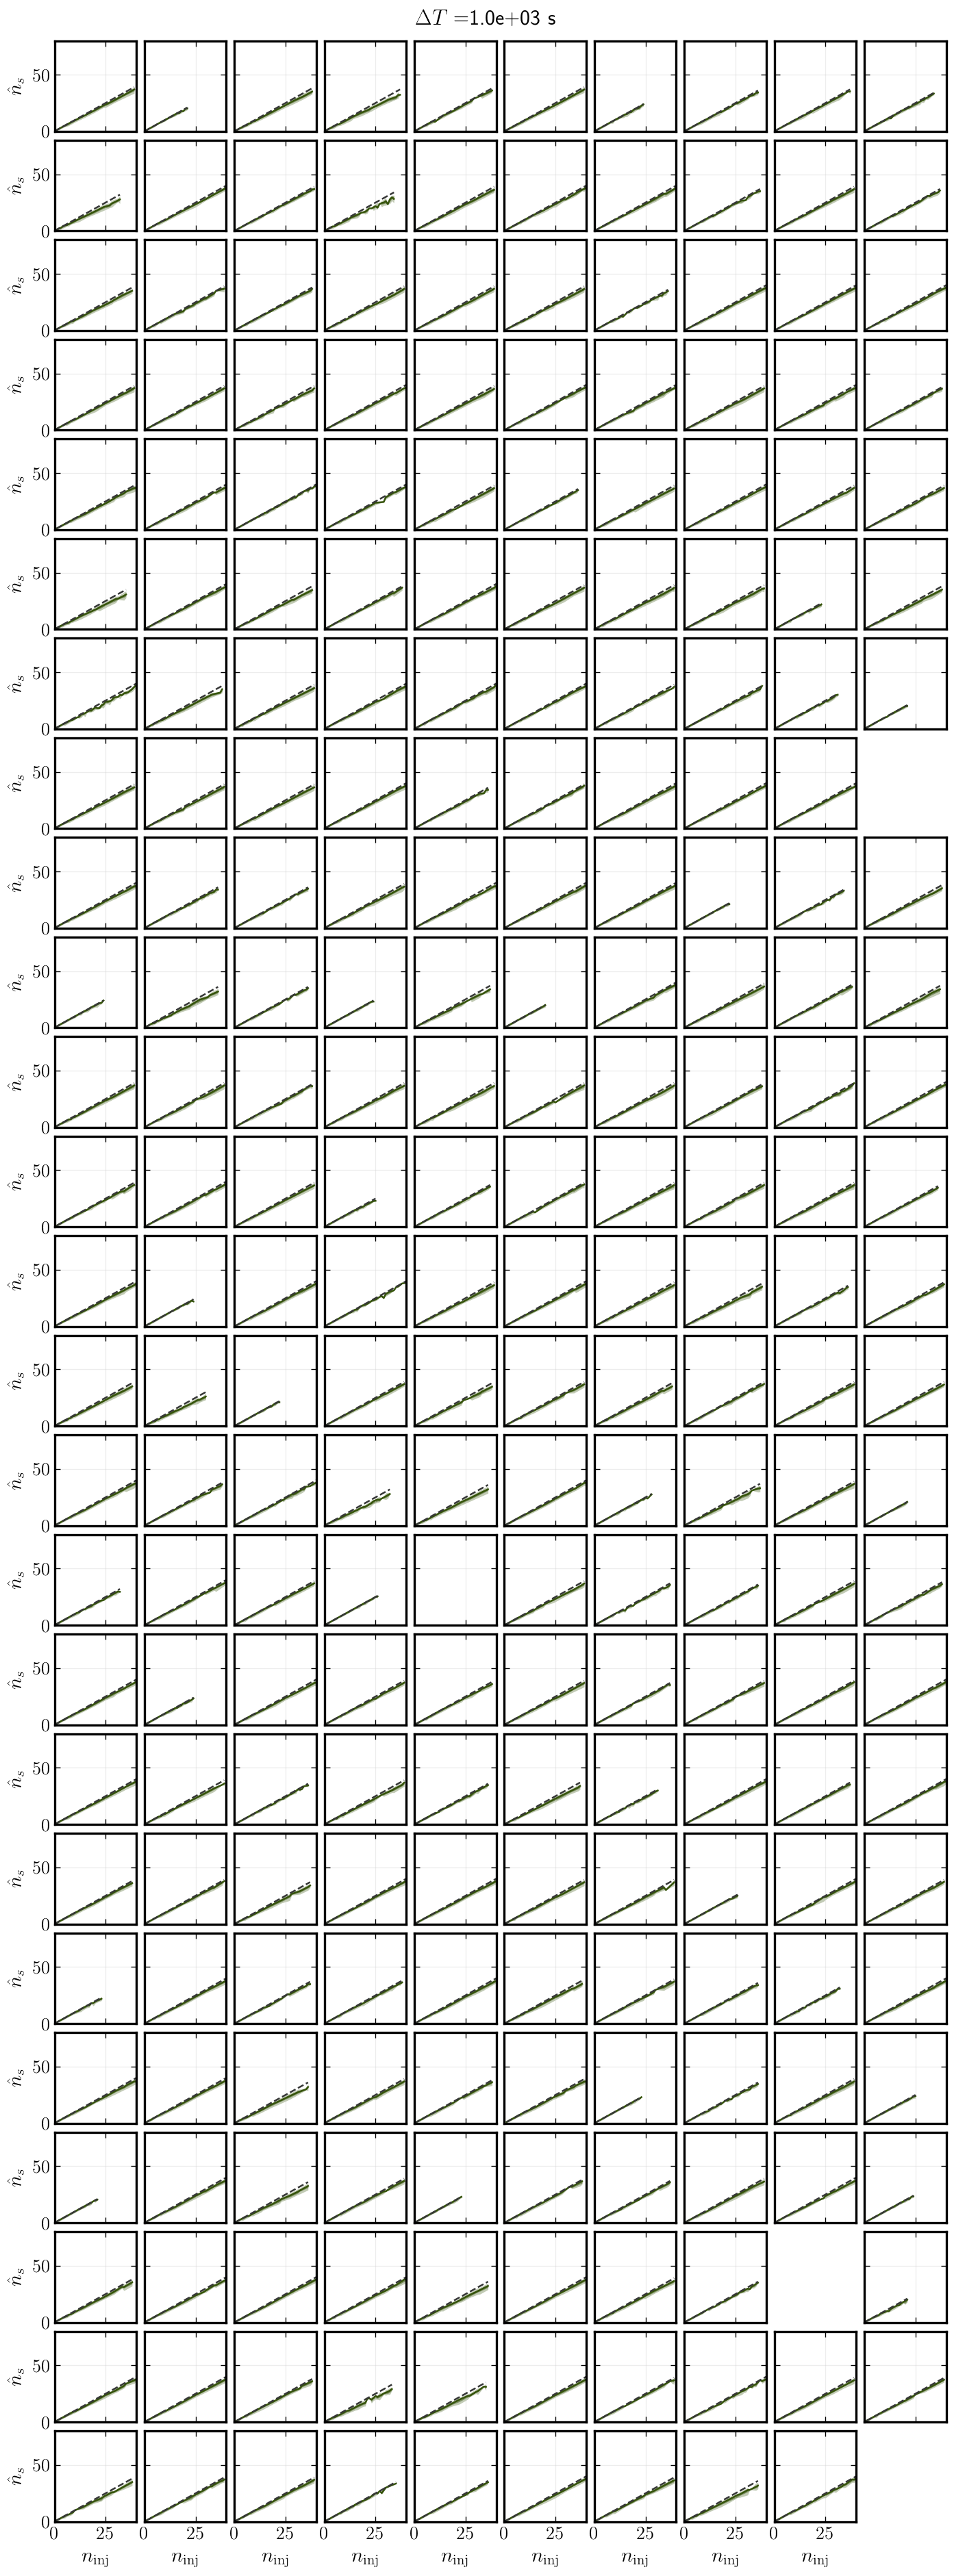

0 25 50 list index out of range
75 100 125 150 Index 154 has max 0


/home/apizzuto/.venvs/fast_response/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0
  'left=%s, right=%s') % (left, right))


175 200 225

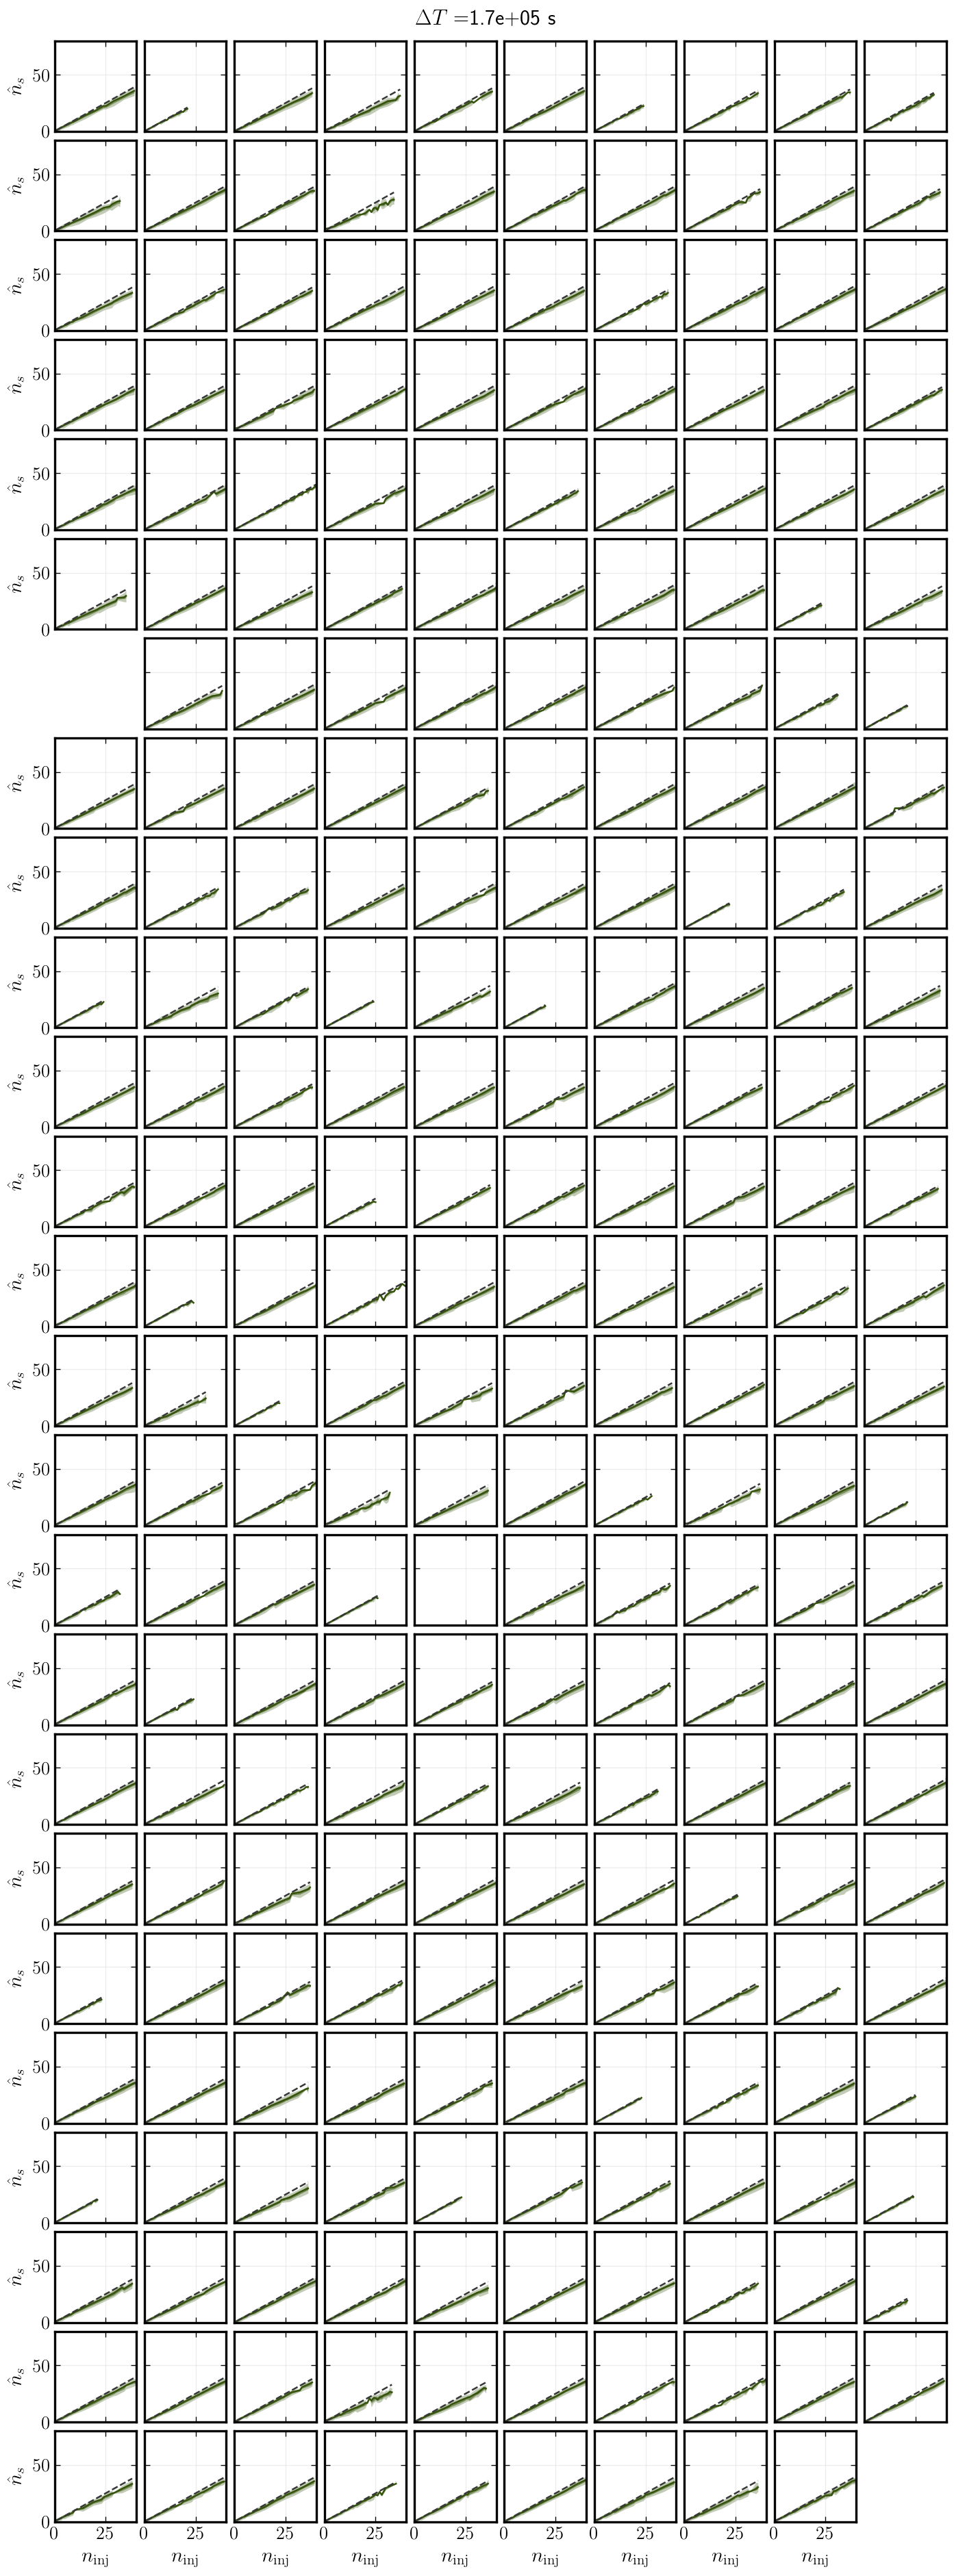

In [9]:
for delta_t in np.array([1000., 2.*86400.]):
    fig, aaxs = plt.subplots(ncols=10, nrows=25, figsize=(14,40), 
                            sharey=True, sharex=True)
    used_axs = []
    axs = aaxs.ravel()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    for ind in range(249):
        xlab = ind / 10 == 24
        ylab = ind % 10 == 0
        if ind % 25 == 0:
            print ind, 
        try:
            ns_fits_contours_plot(ind, delta_t, smear=True, show=False,
                                 ax=axs[ind], xlabel=xlab, ylabel=ylab, legend=False)
            used_axs.append(axs[ind])
        except (IOError, ValueError, IndexError) as err:
            print(err)
    for ax in axs:
        if ax not in used_axs:
            ax.set_visible(False)
    fig.suptitle(r'$\Delta T = $' + '{:.1e} s'.format(delta_t), y=0.89)
    plt.show()

Index 154 has max 0.0


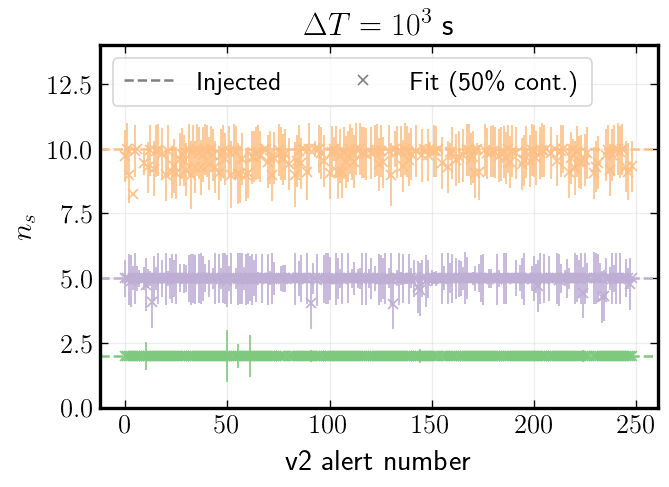

Index 154 has max 0


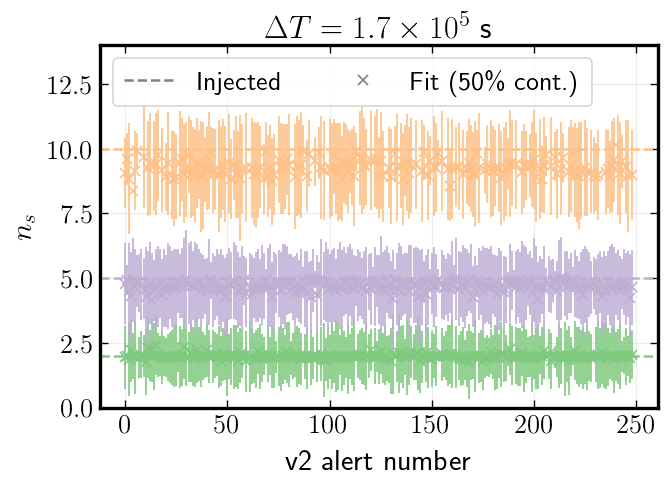

In [11]:
legend_elements = [Line2D([0], [0], color='gray', ls='--', label='Injected'),
                   Line2D([0], [0], marker='x', color='gray', label='Fit (50\% cont.)', ls='')]

for delta_t, delta_t_str in zip([1000., 172800.], 
                                [r'$\Delta T = 10^3$ s', r'$\Delta T = 1.7\times 10^5$ s']):
    bias, spread = fitting_bias_summary(delta_t)
    for ii, sig in enumerate([2.0, 5.0, 10.]):
        msk = np.array(bias[sig]) != 0.
        plt.axhline(sig, ls='--', color=palette[ii])
        plt.errorbar(np.r_[0:249:1][msk], np.array(bias[sig])[msk], yerr=np.array(spread[sig])[msk],
                    marker = 'x', ls='', color=palette[ii], lw=1.)
    plt.ylim(0.0, 14)
    plt.title(delta_t_str)
    plt.xlabel('v2 alert number')
    plt.ylabel(r'$n_s$')
    plt.legend(handles=legend_elements, ncol=2, loc=2)
    plt.show()

# Sensitivity efficiency curve panel plots

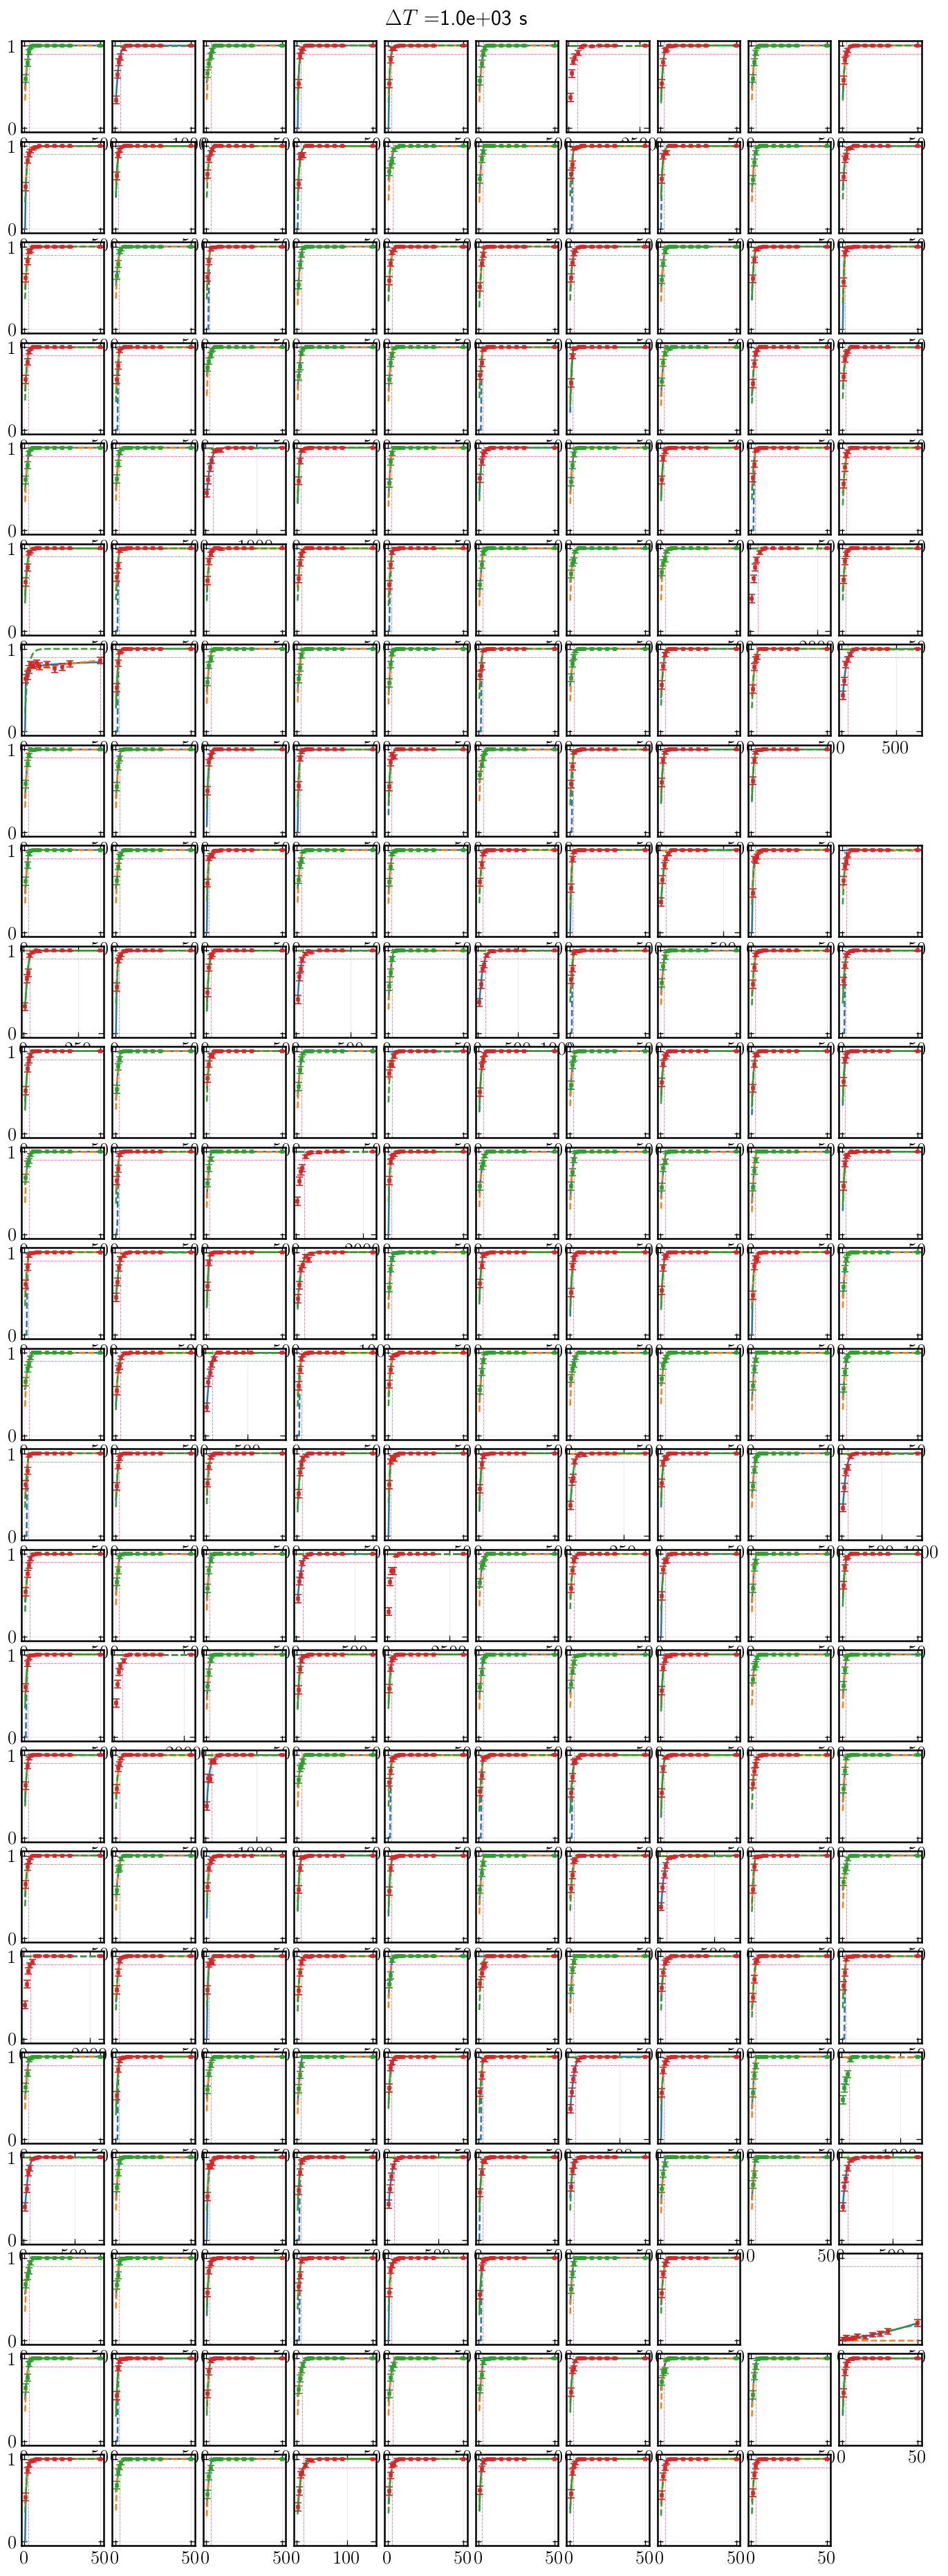

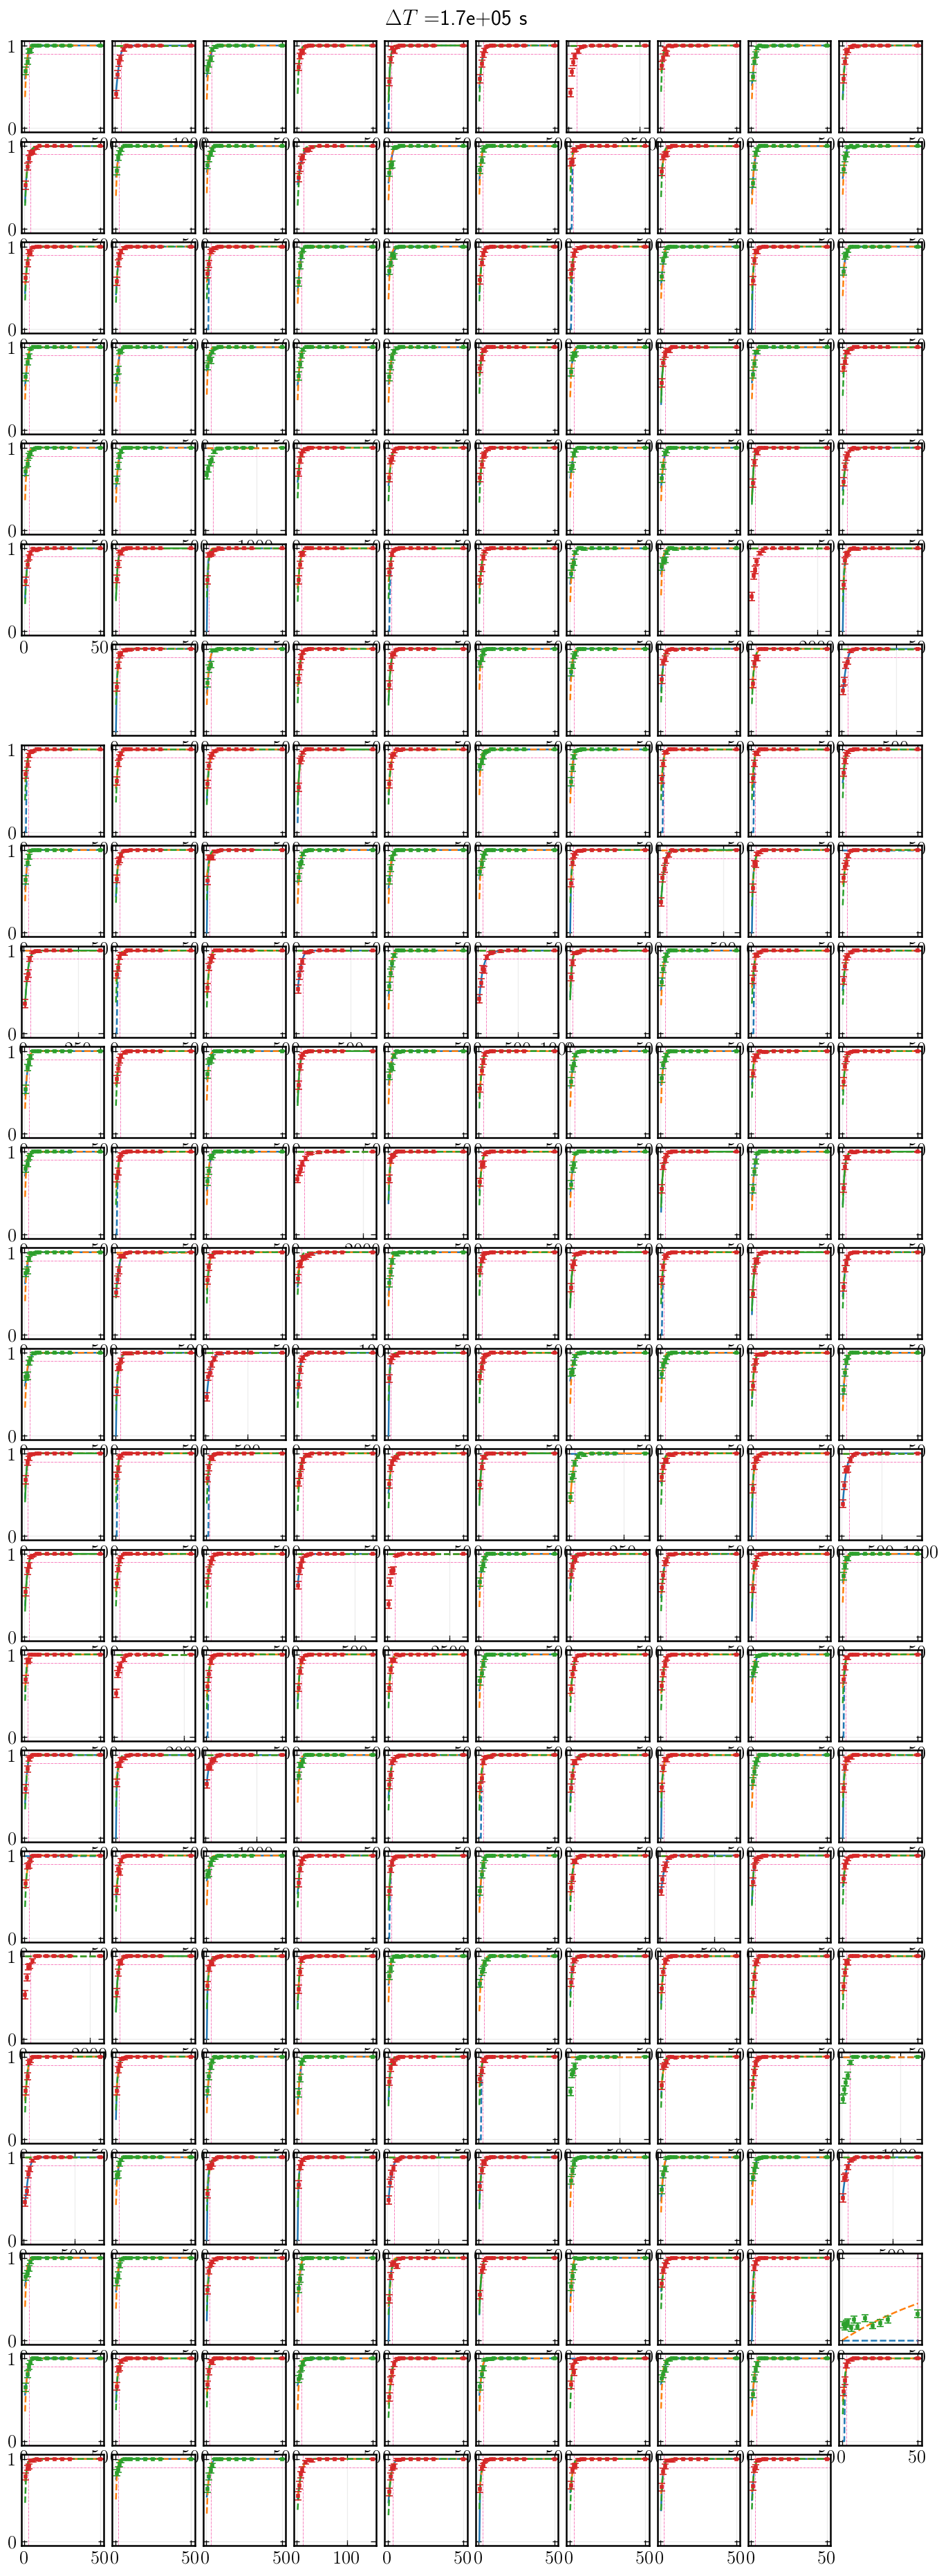

In [4]:
for delta_t in [1e3, 2.*86400.]:#np.append(np.logspace(1., 7., 7), np.array([2.*86400., 31.*86400.])):
    fig, aaxs = plt.subplots(ncols=10, nrows=25, figsize=(14,40), 
                            sharey=True)
    used_axs = []
    axs = aaxs.ravel()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    for ind in range(249):
        try:
            sensitivity_curve(ind, delta_t, ax = axs[ind], in_ns=False, 
                              smear=True, text=False, legend=False)
            used_axs.append(axs[ind])
        except (IOError, ValueError, IndexError) as err:
            pass
    for ax in axs:
        if ax not in used_axs:
            ax.set_visible(False)
    fig.suptitle(r'$\Delta T = $' + '{:.1e} s'.format(delta_t), y=0.89)
    plt.show()

## Let's look at the distribution of hot spots for background only (and signal injected?) trials

In [71]:
sys.path.append('/data/user/apizzuto/fast_response_skylab/fast-response/trunk/time_integrated_scripts/')
from steady_sensitivity_fits import *

def background(index, delta_t, smear=True):
    smear_str = 'smeared/' if smear else 'norm_prob/'
    fs = glob('/data/user/apizzuto/fast_response_skylab/alert_event_followup/analysis_trials/bg/{}index_{}_*_time_{:.1f}.pkl'.format(smear_str, index, delta_t))
    with open(fs[0], 'r') as f:
        bg_trials = pickle.load(f)
    return bg_trials

def plot_zoom_from_map(skymap, ind, reso=1., cmap=None, draw_contour=True, ax=None, 
                      col_label= r'$\log_{10}$(prob.)'):
    s, header = hp.read_map(skymap_files[ind], h=True, verbose=False)
    header = {name: val for name, val in header}
    nside = hp.get_nside(s)
    area = np.count_nonzero(s < 64.2) * hp.nside2pixarea(nside) * 180.**2. / (np.pi**2.)
    reso *= int(np.sqrt(area))
    reso = np.max([reso, 1.])
    original_LLH = s
    ra = np.radians(header['RA'])
    dec = np.radians(header['DEC'])
    title = skymap_files[ind][l_ind:r_ind].replace('Run', 'Run ').replace('_', ', Event ')
    if cmap is None:
        pdf_palette = sns.color_palette("Blues", 500)
        cmap = mpl.colors.ListedColormap(pdf_palette)
    if np.count_nonzero(skymap > 0.0) > 1:
        max_color = np.max(skymap)
        min_color = 0.
    else:
        max_color =  -1.8 #5 #max(skymap)
        min_color = -5.  #0.
    #min_color = np.min([0., 2.*max_color])
    hp.gnomview(skymap, rot=(np.degrees(ra), np.degrees(dec), 0),
                    cmap=cmap,
                    max=max_color,
                    min=min_color,
                    reso=reso,
                    title=title,
                    notext=True,
                    cbar=False
                    #unit=r""
                    )

    plt.plot(4.95/3.*reso*np.radians([-1, 1, 1, -1, -1]), 4.95/3.*reso*np.radians([1, 1, -1, -1, 1]), color="k", ls="-", lw=3)
    hp.graticule(verbose=False)
    plot_labels(dec, ra, reso)
    con_nside = 256 if area < 5. else 128
    if draw_contour:
        contours = plot_contours(None, original_LLH, levels=[22.2, 64.2], nside = con_nside)
        for contour in np.array(contours).T:
            hp.projplot(contour[0],contour[1],linewidth=1.5,c='k')
    plot_color_bar(cmap = cmap, labels = [min_color, max_color], col_label = col_label)

In [ ]:
bg = background(ind, delta_t, smear=smear)
msk = np.array(bg['ts_prior']) != 0.
ra, dec = np.array(bg['ra'])[msk], np.array(bg['dec'])[msk]
theta = np.pi/2. - dec
inds = hp.ang2pix(256, theta, ra)
ind_counts = np.unique(inds, return_counts=True)
reco_hist = np.zeros(hp.nside2npix(256))
reco_hist[ind_counts[0]] = ind_counts[1]
plot_zoom_from_map(reco_hist, ind, draw_contour=False, col_label='Counts')
  
    
def scale_2d_gauss(arr, sigma_arr, new_sigma):
    tmp = arr**(sigma_arr**2. / new_sigma**2.)/(np.sqrt(2.*np.pi)*new_sigma)* \
                    np.power(np.sqrt(2.*np.pi)*sigma_arr, (sigma_arr**2. / new_sigma**2.))
    return tmp / np.sum(tmp)

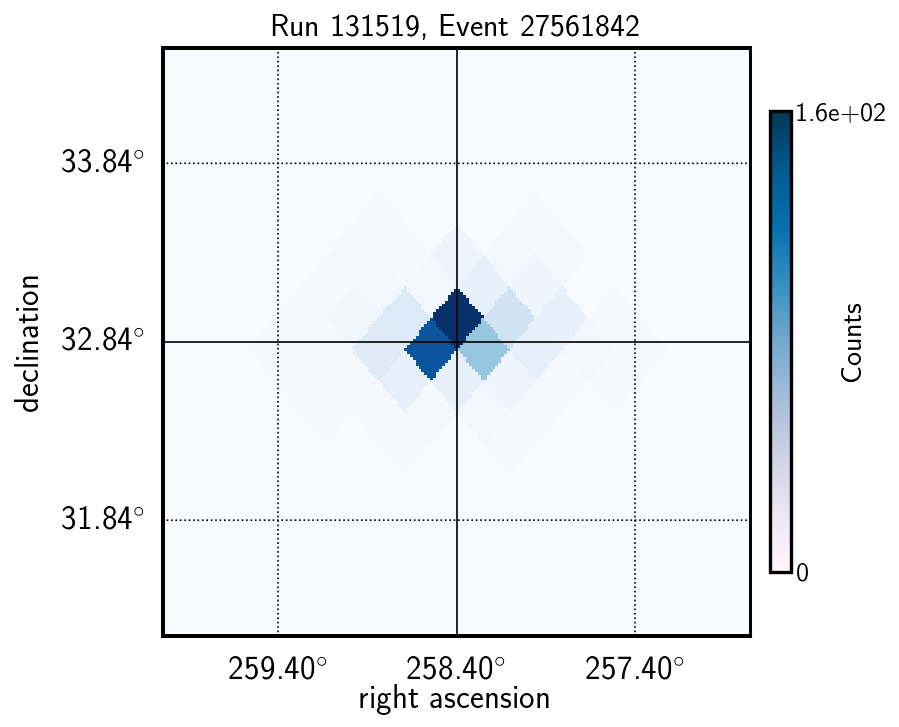

In [5]:
background_hotspot_map(2, 2.*86400)

(312.63, 20.07)
(74.14, -17.74)
(258.4, 32.84)
(324.58000000000004, 51.74)
(58.71, 0.7800000000000001)
(245.57, 21.98)
(225.22, -34.95)
(138.47, -1.9399999999999997)
(140.01, -0.11)
(235.63, -4.07)


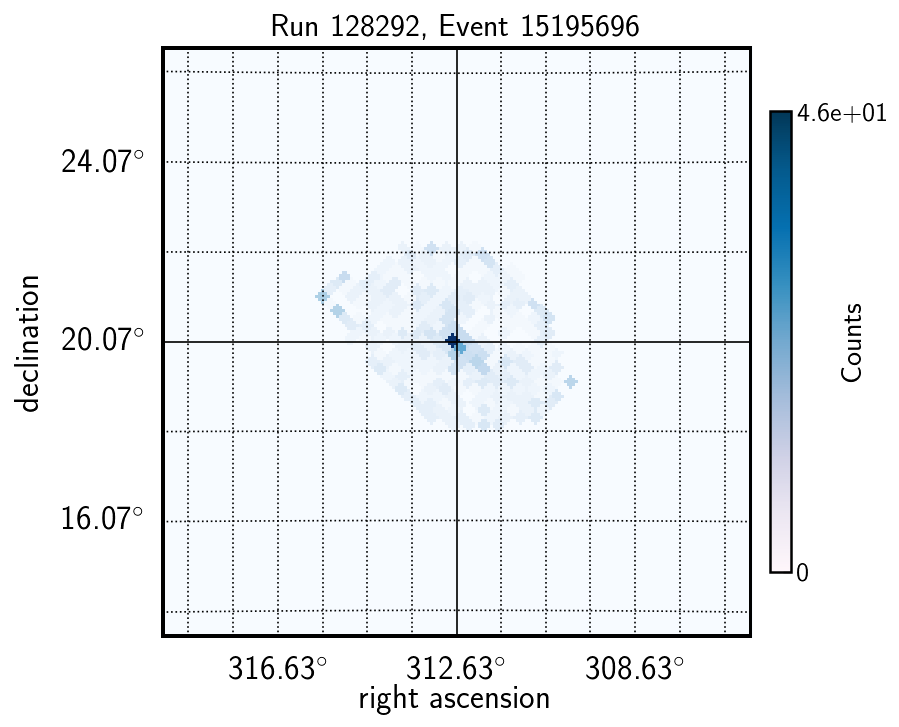

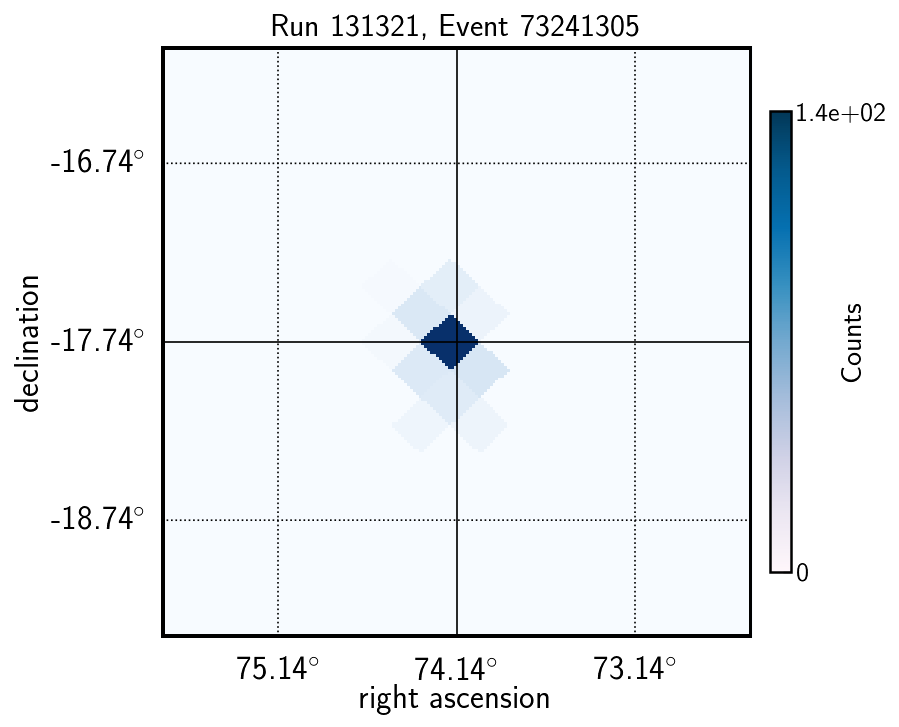

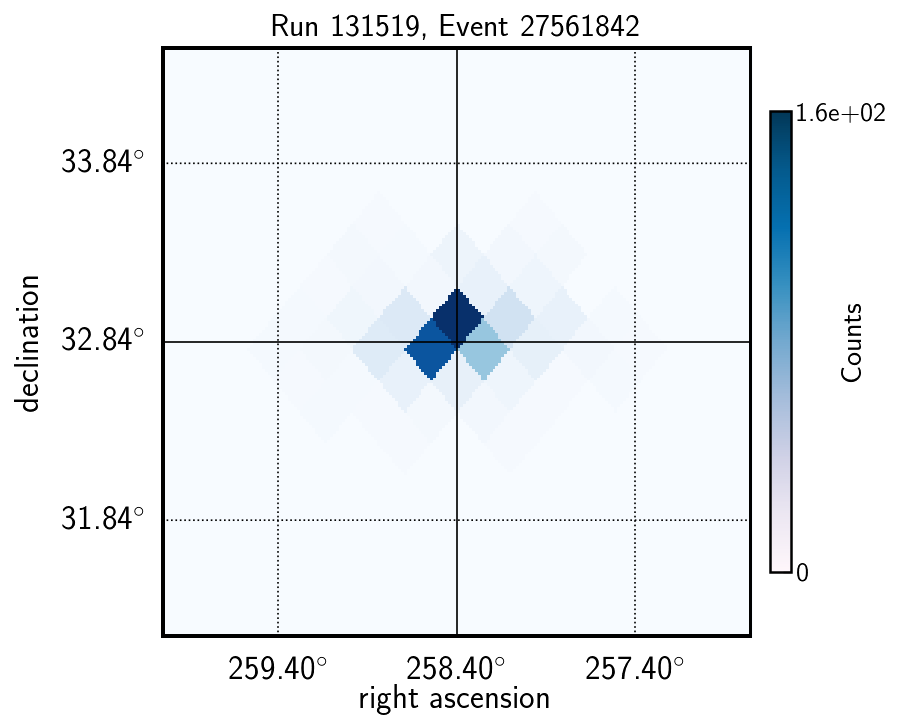

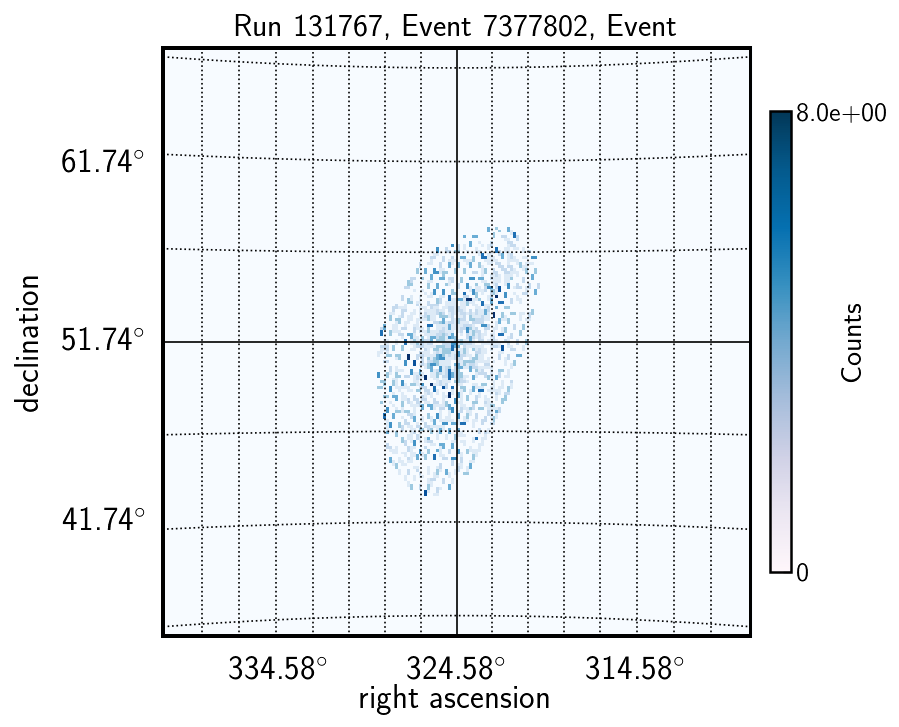

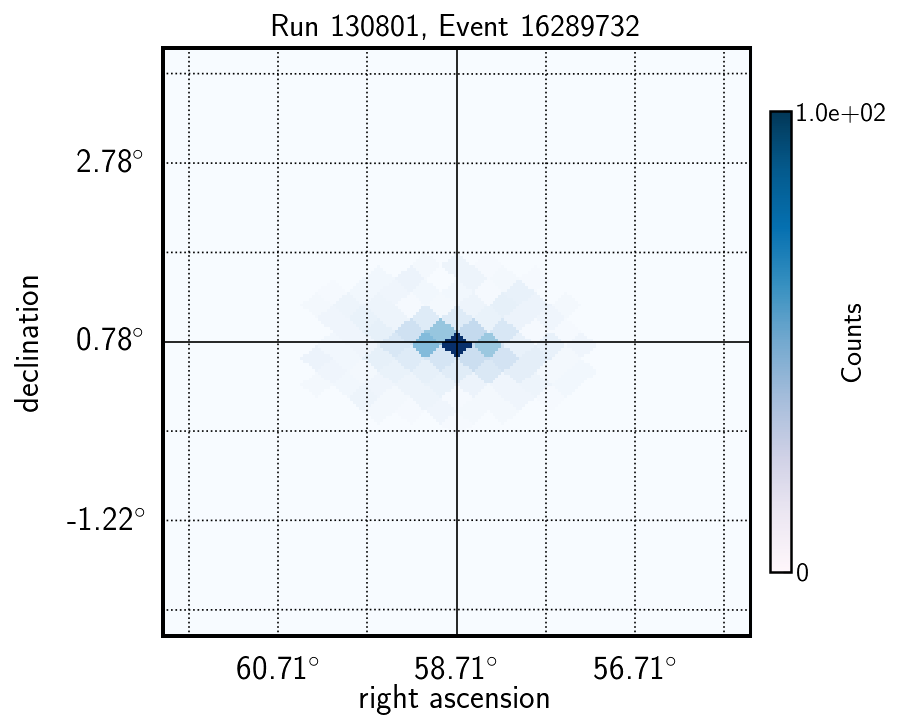

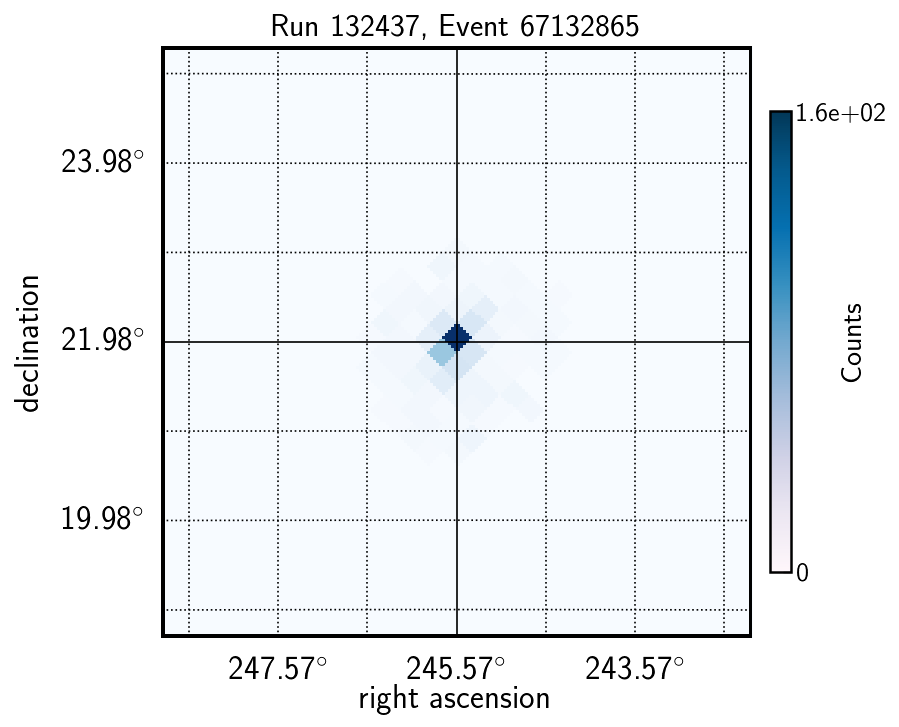

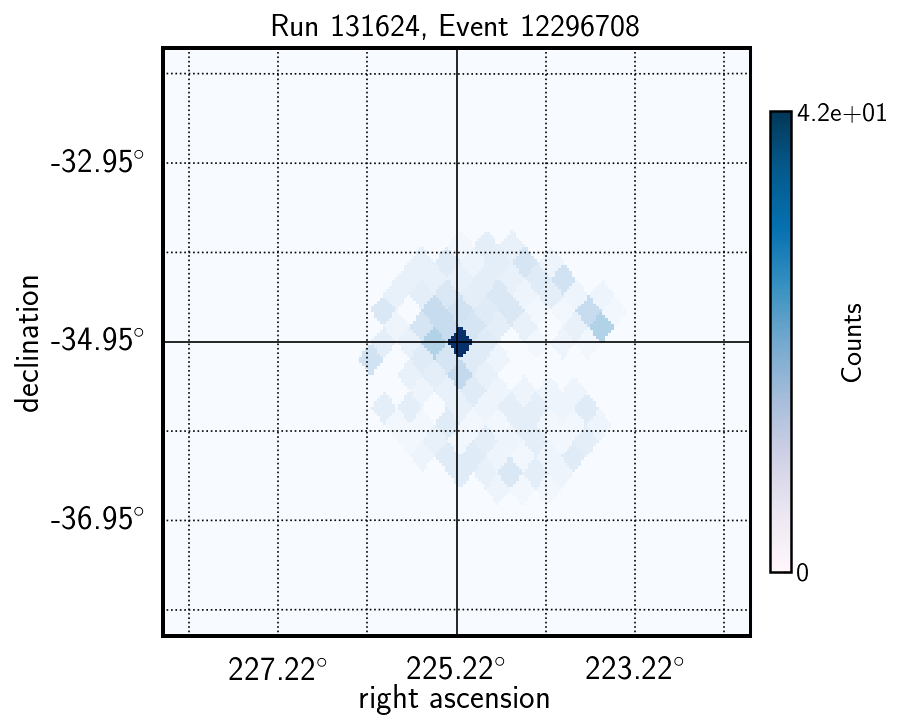

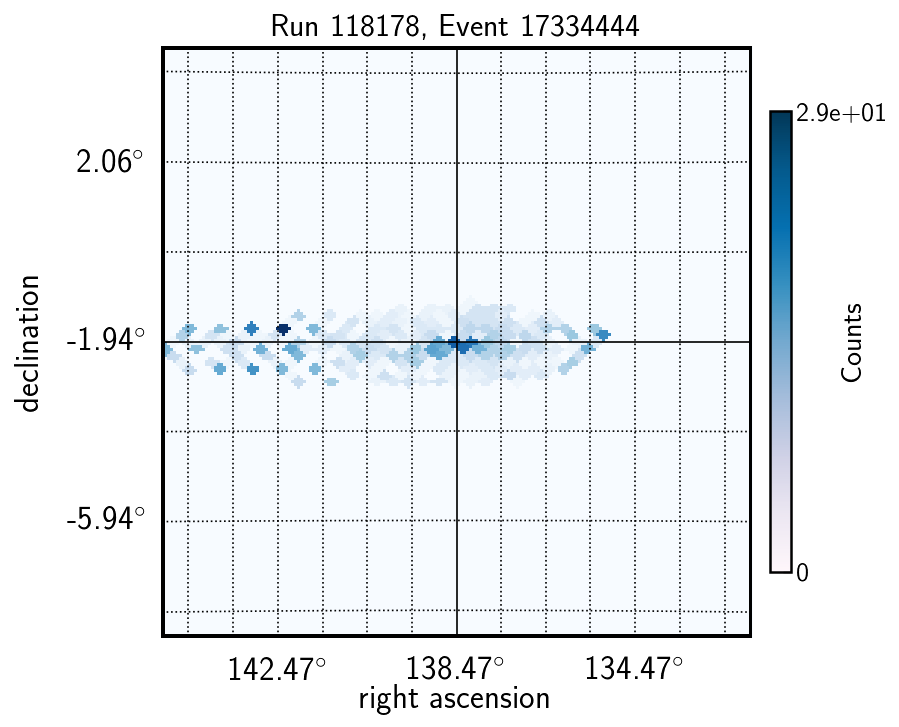

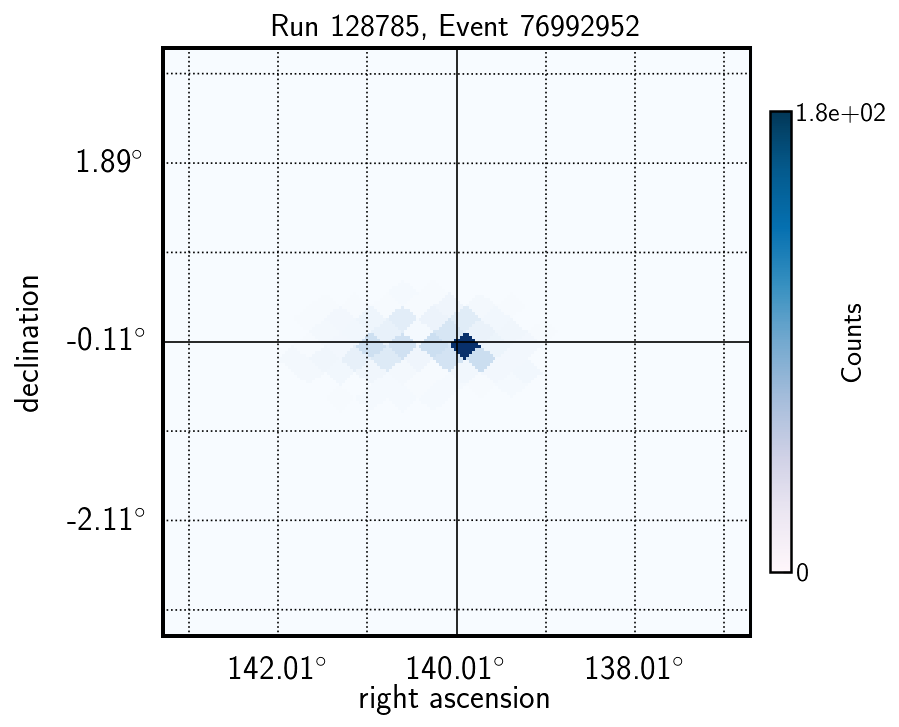

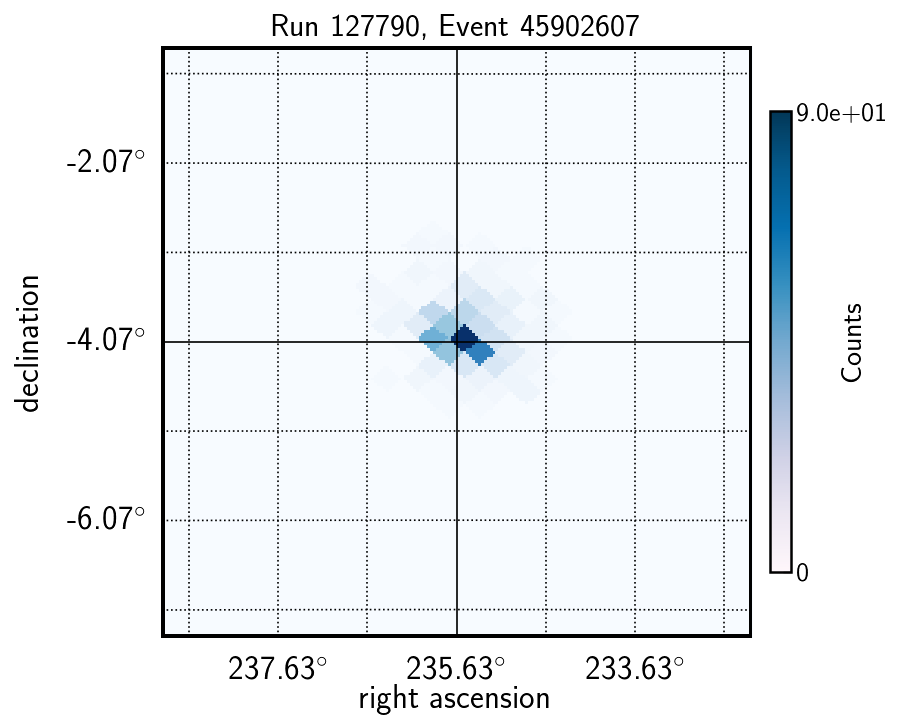

In [70]:
delta_t = 2.*86400

for ind in range(10):
    bg = background(ind, delta_t, smear=True)
    msk = np.array(bg['ts_prior']) != 0.
    ra, dec = np.array(bg['ra'])[msk], np.array(bg['dec'])[msk]

    theta = np.pi/2. - dec
    inds = hp.ang2pix(256, theta, ra)
    ind_counts = np.unique(inds, return_counts=True)
    reco_hist = np.zeros(hp.nside2npix(256))
    reco_hist[ind_counts[0]] = ind_counts[1]

    plot_zoom_from_map(reco_hist, ind, draw_contour=False, col_label='Counts')
    plt.show()

# DO this for opening angle for simulation between true injection and reco

In [5]:
def deltaPsi(dec1, ra1, dec2, ra2):
    """
    Calculate angular distance.
    
    Args:
        dec1: Declination of first direction in radian
        ra1: Right ascension of first direction in radian
        dec2: Declination of second direction in radian
        ra2: Right ascension of second direction in radian
        
    Returns angular distance in radian
    """
    return deltaPsi2(np.sin(dec1), np.cos(dec1), np.sin(ra1), np.cos(ra1), np.sin(dec2), np.cos(dec2), np.sin(ra2), np.cos(ra2))

def deltaPsi2(sDec1, cDec1, sRa1, cRa1, sDec2, cDec2, sRa2, cRa2):
    """
    Calculate angular distance.
    
    Args:
        sDec1: sin(Declination of first direction)
        cDec1: cos(Declination of first direction)
        sRa1: sin(Right ascension of first direction)
        cRa1: cos(Right ascension of first direction)
        sDec2: sin(Declination of second direction)
        cDec2: cos(Declination of second direction)
        sRa2: sin(Right ascension of second direction)
        cRa2: cos(Right ascension of second direction)
        
    Returns angular distance in radian
    """
    tmp = cDec1*cRa1*cDec2*cRa2 + cDec1*sRa1*cDec2*sRa2 + sDec1*sDec2
    tmp[tmp>1.] = 1.
    tmp[tmp<-1.] = -1.
    return np.arccos(tmp)

def signal_distribution(index, delta_t, ns, smear=True):
    smear_str = 'smeared/' if smear else 'norm_prob/'
    fs = glob('/data/user/apizzuto/fast_response_skylab/alert_event_followup/analysis_trials/sensitivity/{}index_{}_*_time_{:.1f}.pkl'.format(smear_str, index, delta_t))
    with open(fs[0], 'r') as f:
        signal_trials = pickle.load(f)
    ret = {}
    msk = np.array(signal_trials['true_ns']) == ns
    for k, v in signal_trials.iteritems():
        ret[k] = np.array(v)[msk]
    return ret

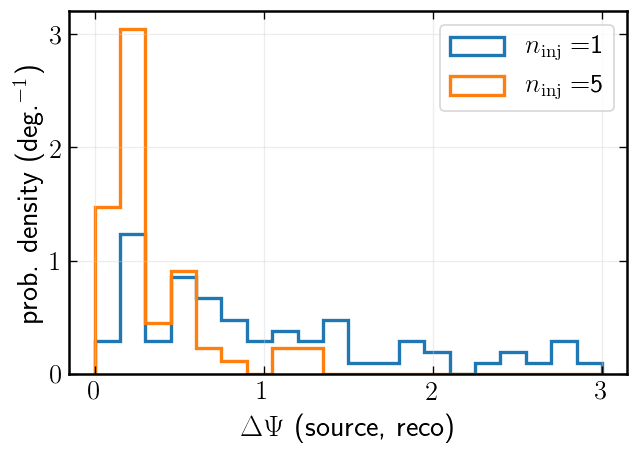

In [12]:
for ninj in np.linspace(1, 5, 2).astype(int):
    signal = signal_distribution(ind, delta_t, ninj, smear=True)
    inj_ra, inj_dec = signal['true_ra'], signal['true_dec']
    reco_ra, reco_dec = signal['ra'], signal['dec']
    del_psi = deltaPsi(reco_dec, reco_ra, inj_dec, inj_ra)
    del_psi *= 180. / np.pi
    plt.hist(del_psi, bins=np.linspace(0., 3., 21), histtype='step', lw=2., 
             density=True, label = r'$n_{\mathrm{inj}}=$' + str(ninj))
plt.ylabel(r'prob. density (deg.$^{-1}$)')
plt.xlabel(r'$\Delta \Psi$ (source, reco)')
plt.legend(loc=1)
plt.show()

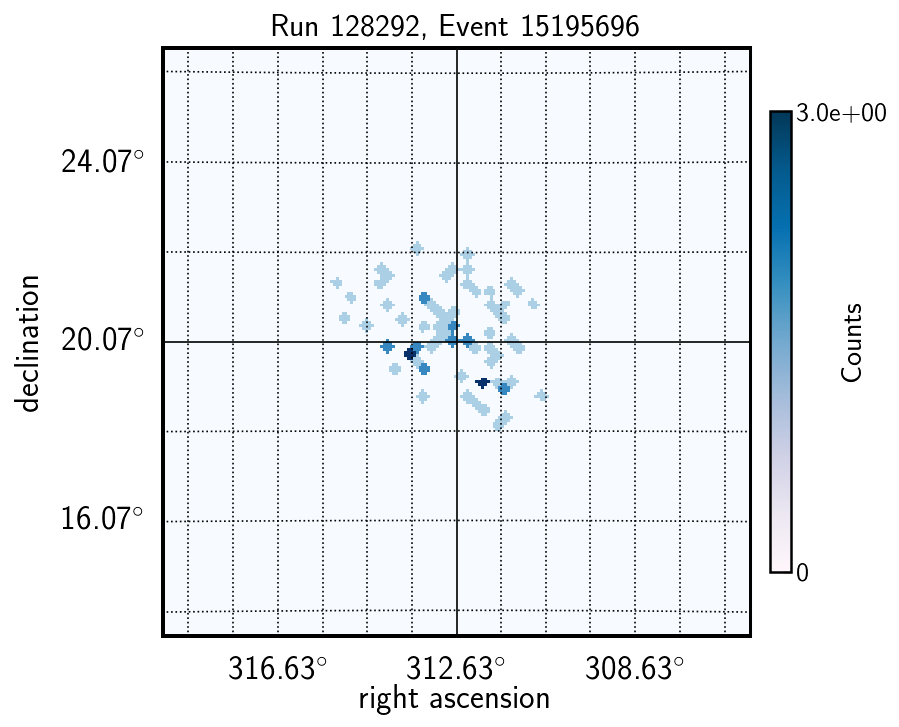

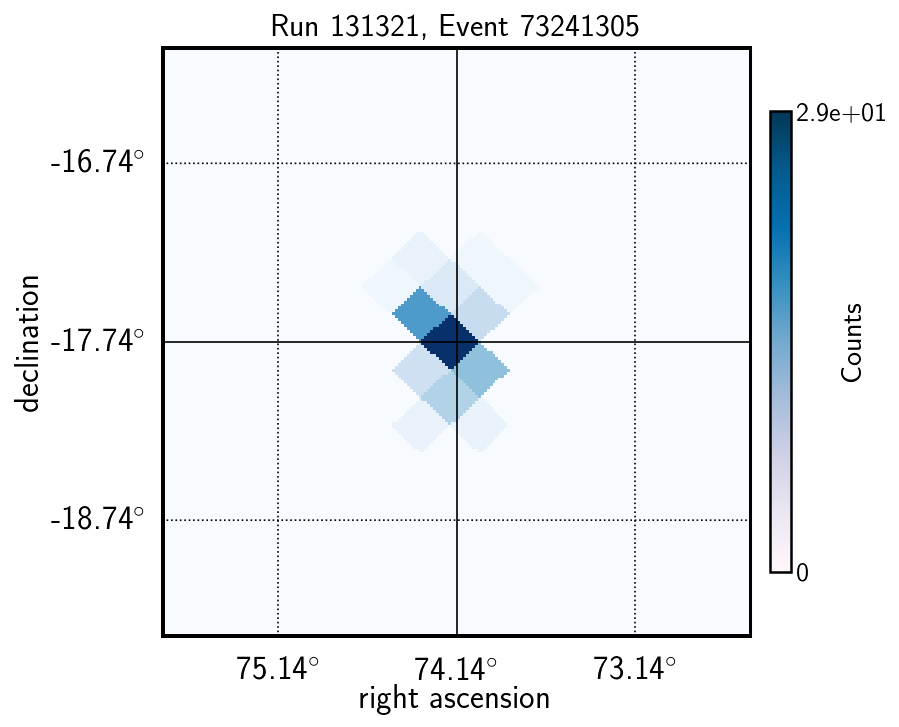

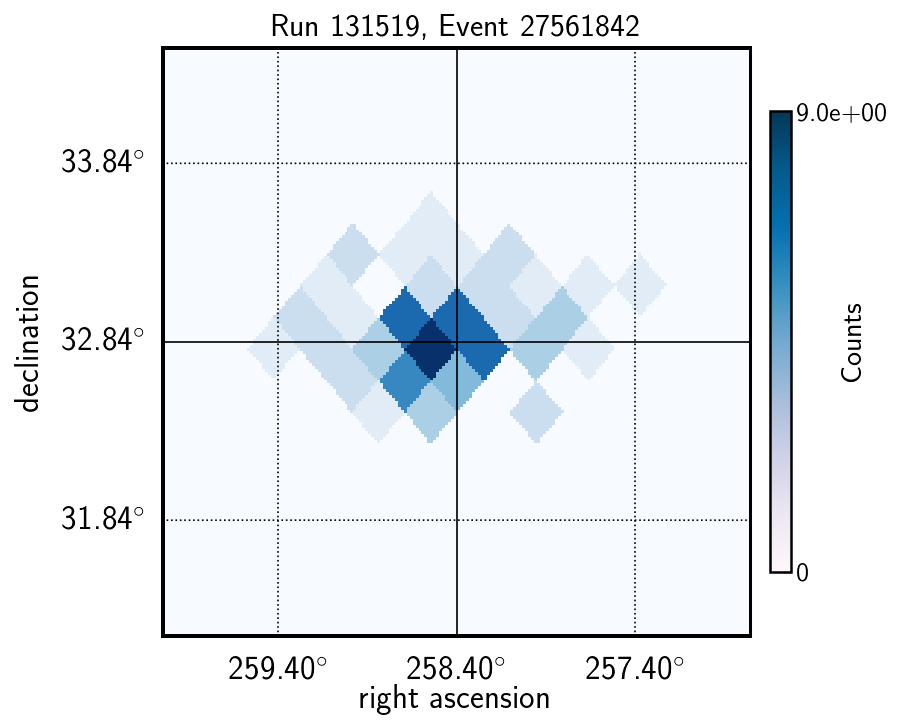

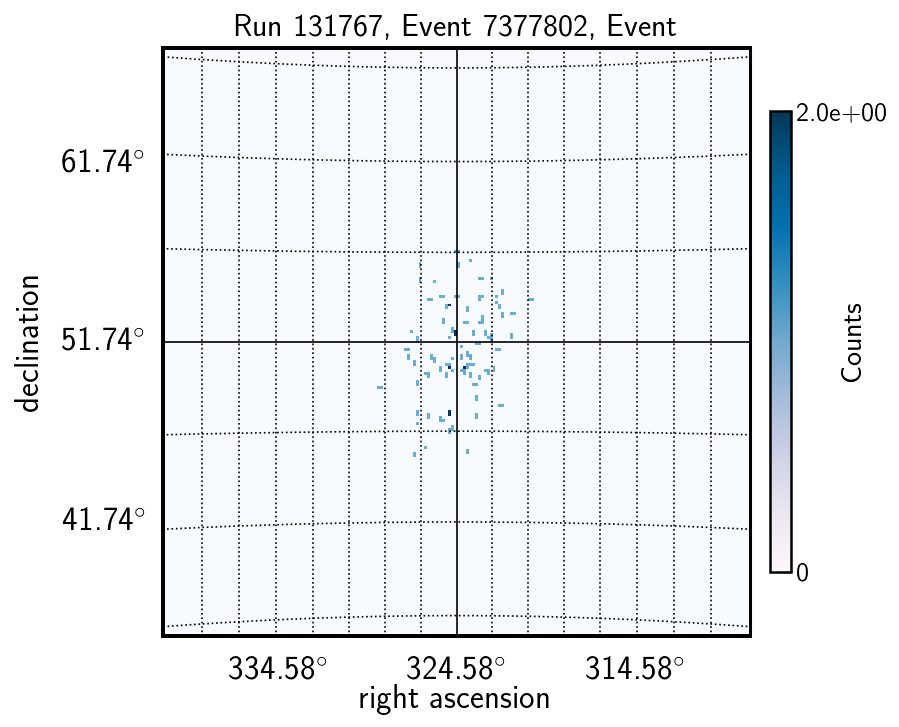

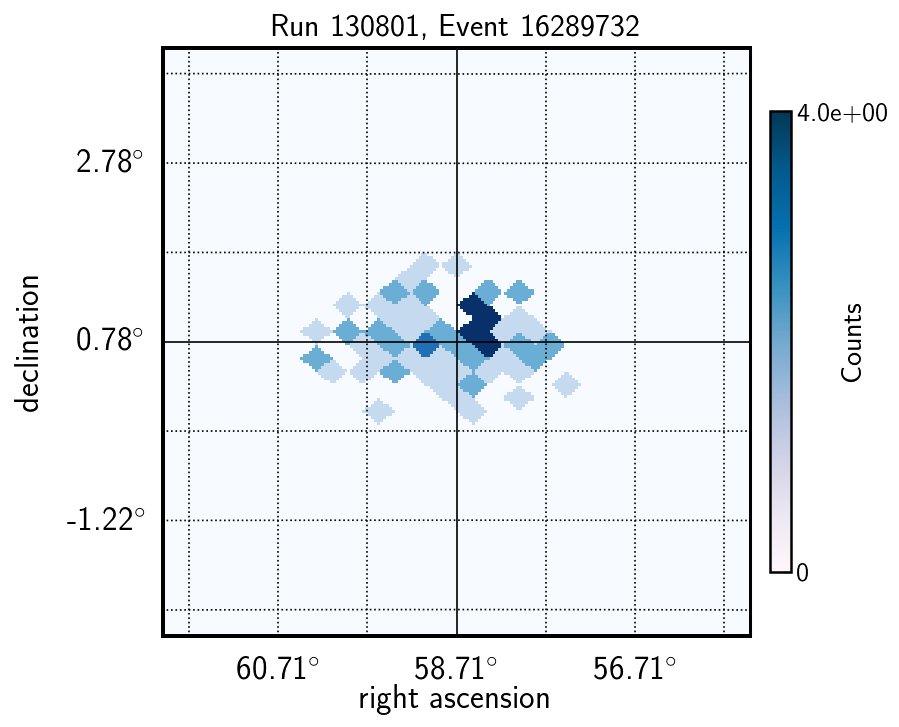

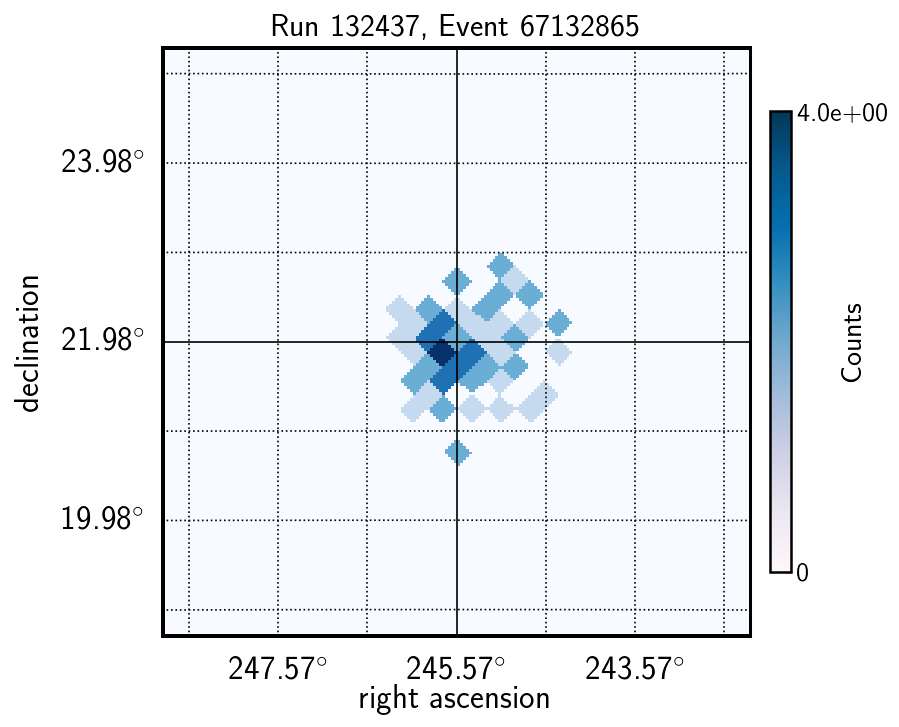

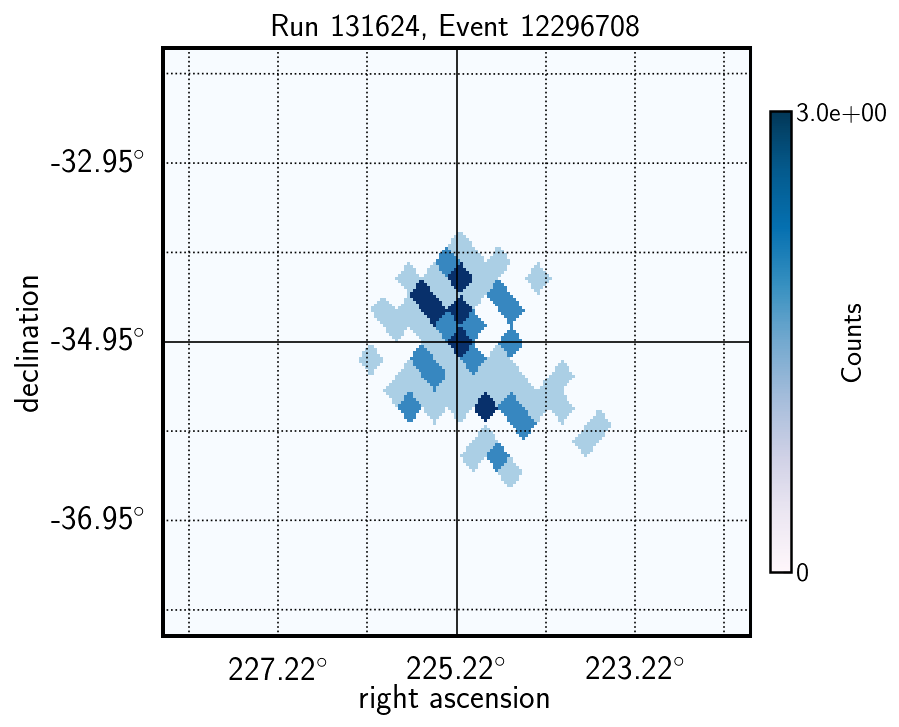

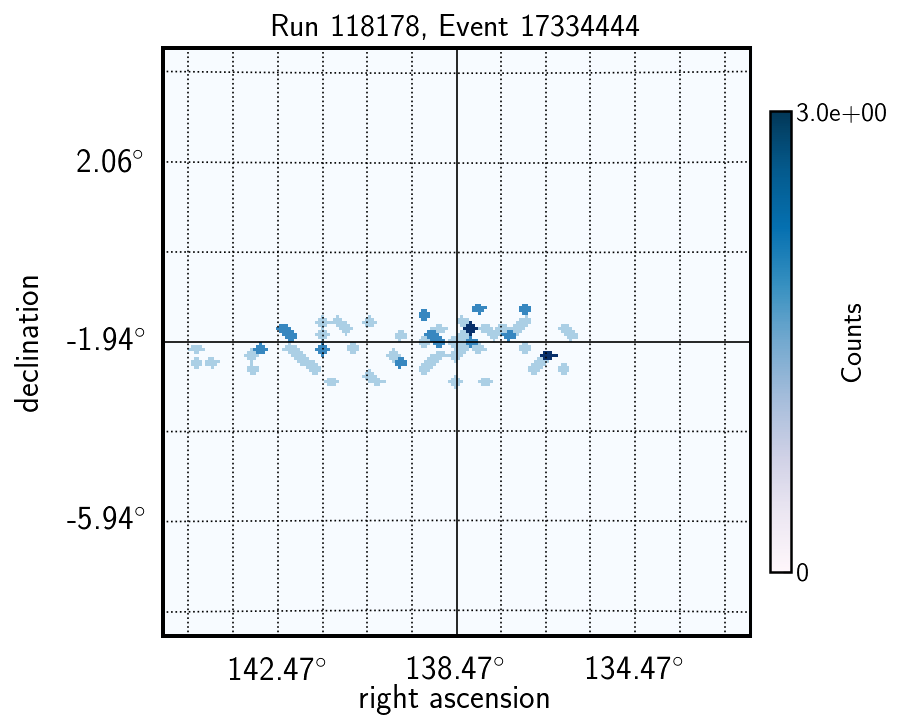

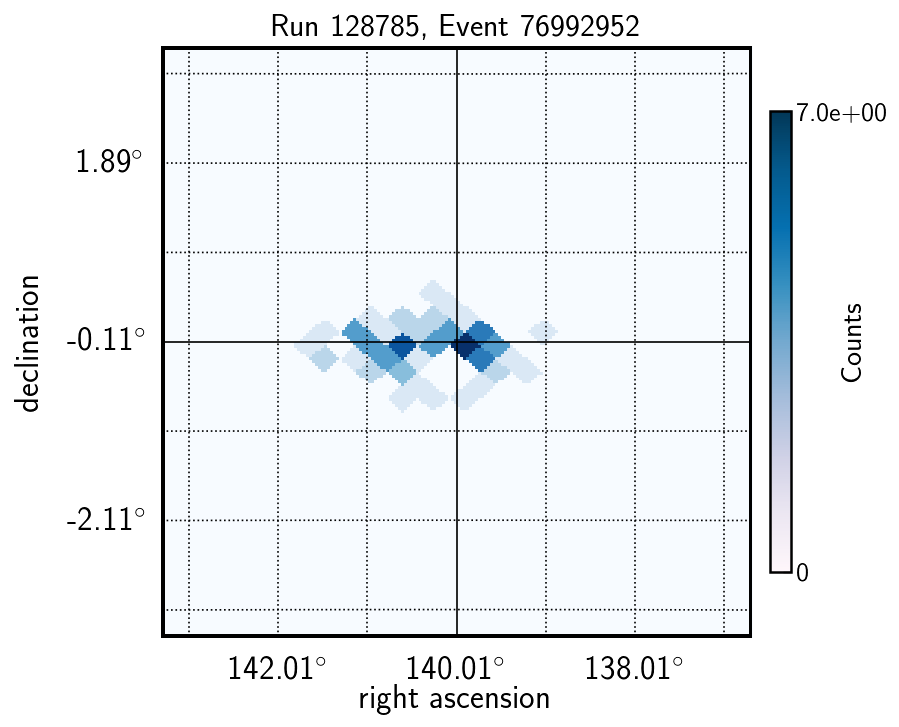

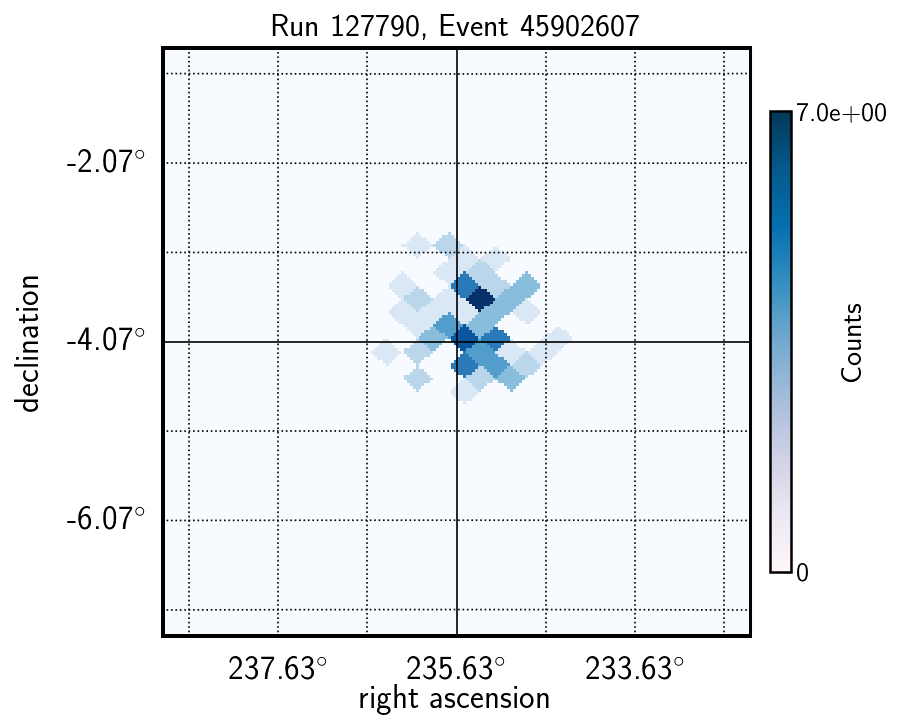

In [100]:
delta_t = 2.*86400
ninj=3
for ind in range(10):
    signal = signal_distribution(ind, delta_t, ninj, smear=True)
    msk = np.array(signal['ts_prior']) != 0.
    ra, dec = np.array(signal['ra'])[msk], np.array(signal['dec'])[msk]

    theta = np.pi/2. - dec
    inds = hp.ang2pix(256, theta, ra)
    ind_counts = np.unique(inds, return_counts=True)
    reco_hist = np.zeros(hp.nside2npix(256))
    reco_hist[ind_counts[0]] = ind_counts[1]

    plot_zoom_from_map(reco_hist, ind, draw_contour=False, col_label='Counts')
    plt.show()

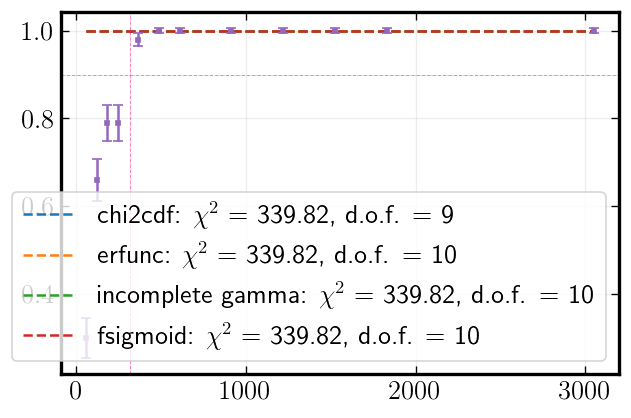

In [13]:
sensitivity_curve(154, 1000.)